<a href="https://colab.research.google.com/github/harshithach999/Data-Science-Project/blob/main/Analysis_Models_LLM_Detect_AI_Generated_Text.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading the Data Set

In [ ]:
!pip install textstat
import textstat

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.1/105.1 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 12.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.utils import shuffle
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.chunk import RegexpParser
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk import pos_tag, RegexpParser
from textblob import TextBlob
from textstat import flesch_reading_ease, lexicon_count
from tabulate import tabulate
import nltk

In [ ]:
# Download necessary NLTK resources only once
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet', quiet=True)
nltk.download('maxent_ne_chunker')
nltk.download('averaged_perceptron_tagger', quiet=True)
nltk.download('vader_lexicon', quiet=True)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.


True

In [ ]:
file_paths = ['LLM_generated_essay_PaLM.csv', 'train_essays.csv']  # file paths


In [ ]:

# Function to load and preprocess data
def load_and_preprocess_data(file_paths):
    dfs = [pd.read_csv(file_path) for file_path in file_paths]
    data = pd.concat(dfs, ignore_index=True)
    # Remove 'id' column
    data = data.drop('id', axis=1)

# Convert 'prompt_id' and 'generated' columns from float to integer
    data['prompt_id'] = data['prompt_id'].astype(int)
    data['generated'] = data['generated'].astype(int)
    return data



In [ ]:
data = load_and_preprocess_data(file_paths)

In [ ]:

data = shuffle(data)
data = data.reset_index(drop=True)


In [ ]:
"""
data = pd.read_csv('newtest.csv')
data.drop('prompt_id',axis=1,inplace=True)
"""

"\ndata = pd.read_csv('newtest.csv')\ndata.drop('prompt_id',axis=1,inplace=True)\n"

In [ ]:
data.head()

,prompt_id,text,generated
0,0,"As the world's population continues to grow, s...",1
1,1,"Dear State Senator, While I normally don't hav...",0
2,0,Humans have a long and complicated relationshi...,1
3,1,"Dear Senator,\n\nI am writing to you today to ...",1
4,1,For the vote for the president of the United S...,0


#Initial Data analysis

###Word count

In [ ]:

def word_count(text):
    return len(text.split())

data['word_count'] = data['text'].apply(word_count)

ai_essays = data[data['generated'] == 1]
human_essays = data[data['generated'] == 0]


ai_word_count_stats = ai_essays['word_count'].describe()
human_word_count_stats = human_essays['word_count'].describe()

print(ai_word_count_stats)
print(human_word_count_stats)

count    1387.000000
mean      383.813987
std        74.960297
min       184.000000
25%       333.000000
50%       382.000000
75%       433.000000
max       746.000000
Name: word_count, dtype: float64
count    1375.000000
mean      556.768727
std       159.493454
min       268.000000
25%       447.500000
50%       525.000000
75%       639.000000
max      1360.000000
Name: word_count, dtype: float64


###Number of AI essays vs Number of Human essays

generated
0    1375
1    1387
Name: text, dtype: int64


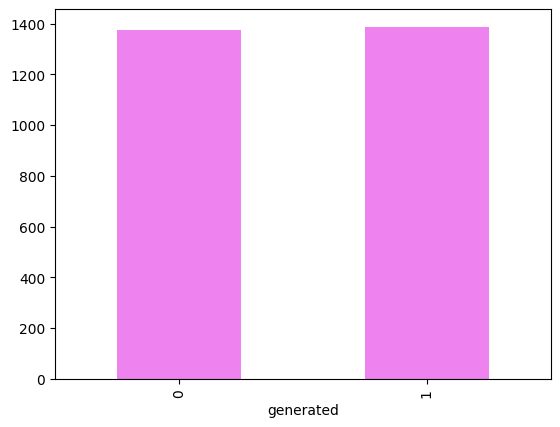

In [ ]:
print(data.groupby(['generated'])['text'].count())
data.groupby(['generated'])['text'].count().plot(kind="bar",color='violet')
plt.show()

## Number of essays with prompt 0 and prompt 1

prompt_id
0    1420
1    1342
Name: text, dtype: int64


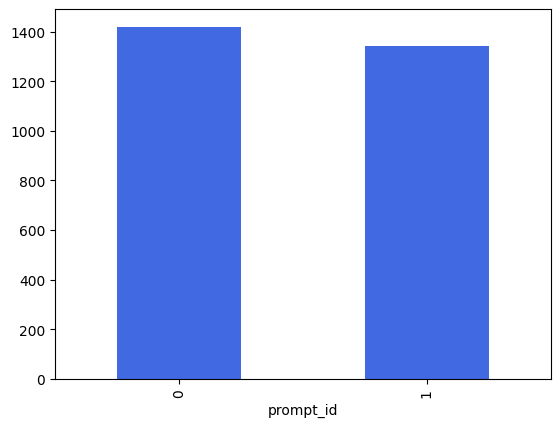

In [ ]:
print(data.groupby(['prompt_id'])['text'].count())
data.groupby(['prompt_id'])['text'].count().plot(kind="bar",color='royalblue')
plt.show()

##WordClouds

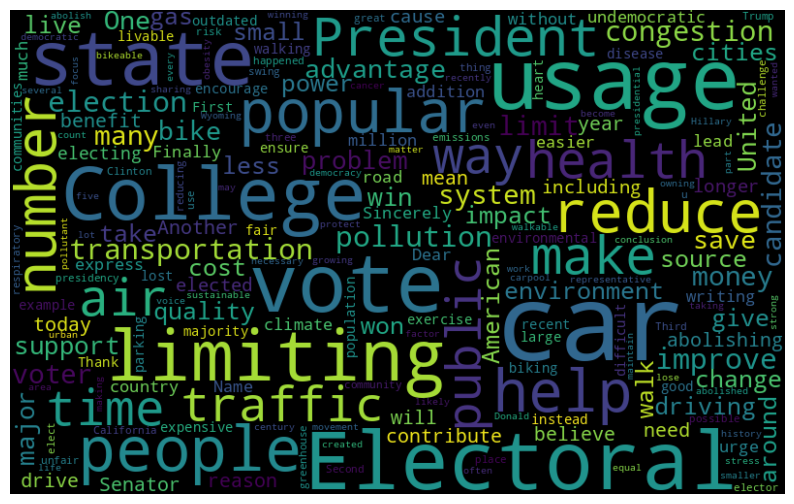

In [ ]:
from wordcloud import WordCloud

dataai = data[data["generated"] == 1]
all_words = ' '.join([text for text in dataai.text])

wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(all_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

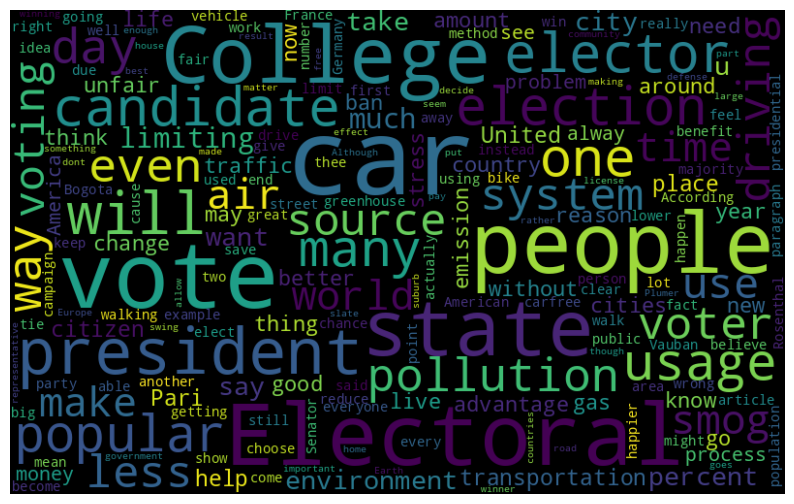

In [ ]:
datahuman = data[data["generated"] == 0]
all_words = ' '.join([text for text in datahuman.text])

wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(all_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

###Text Frequencies

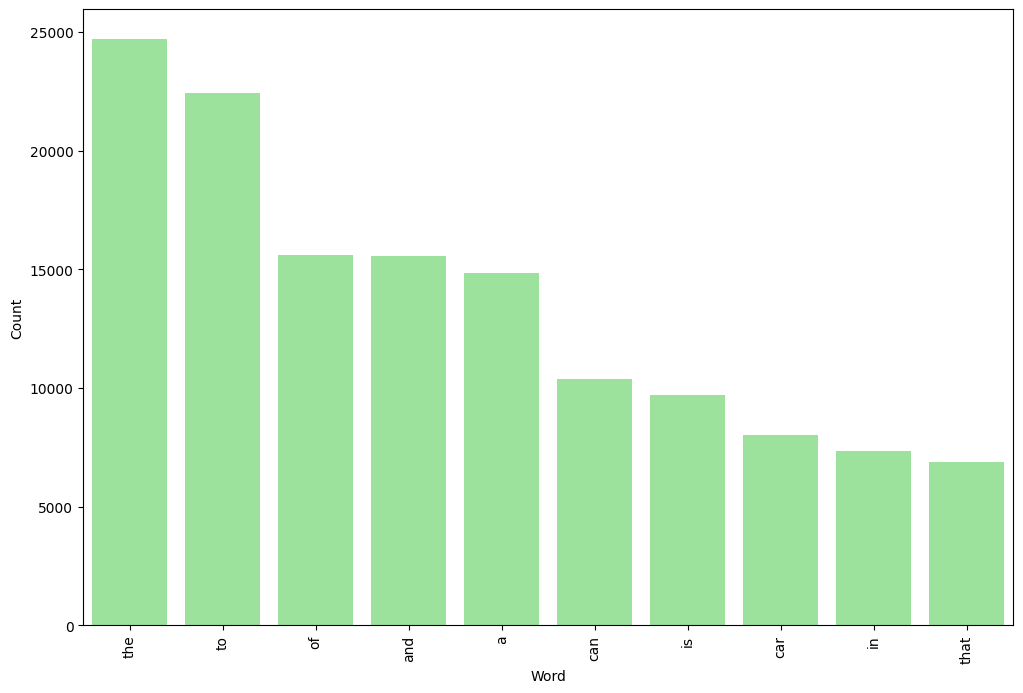

In [ ]:
from nltk import tokenize
from collections import Counter

token_space = tokenize.WhitespaceTokenizer()

def counter(text, column_text, quantity):
    all_words = ' '.join([text for text in text[column_text]])
    token_phrase = token_space.tokenize(all_words)
    frequency = nltk.FreqDist(token_phrase)
    df_frequency = pd.DataFrame({"Word": list(frequency.keys()),
                                   "Frequency": list(frequency.values())})
    df_frequency = df_frequency.nlargest(columns = "Frequency", n = quantity)
    plt.figure(figsize=(12,8))
    ax = sns.barplot(data = df_frequency, x = "Word", y = "Frequency", color = 'lightgreen')
    ax.set(ylabel = "Count")
    plt.xticks(rotation='vertical')
    plt.show()

counter(data[data["generated"] == 1], "text", 10)

###Word Frequencies

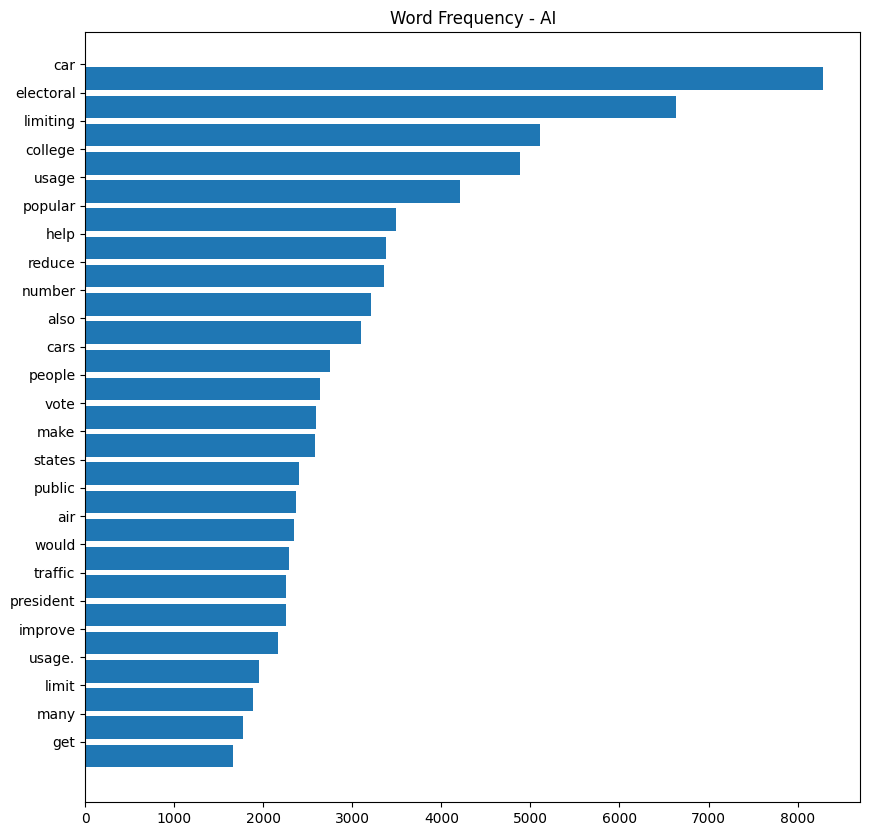

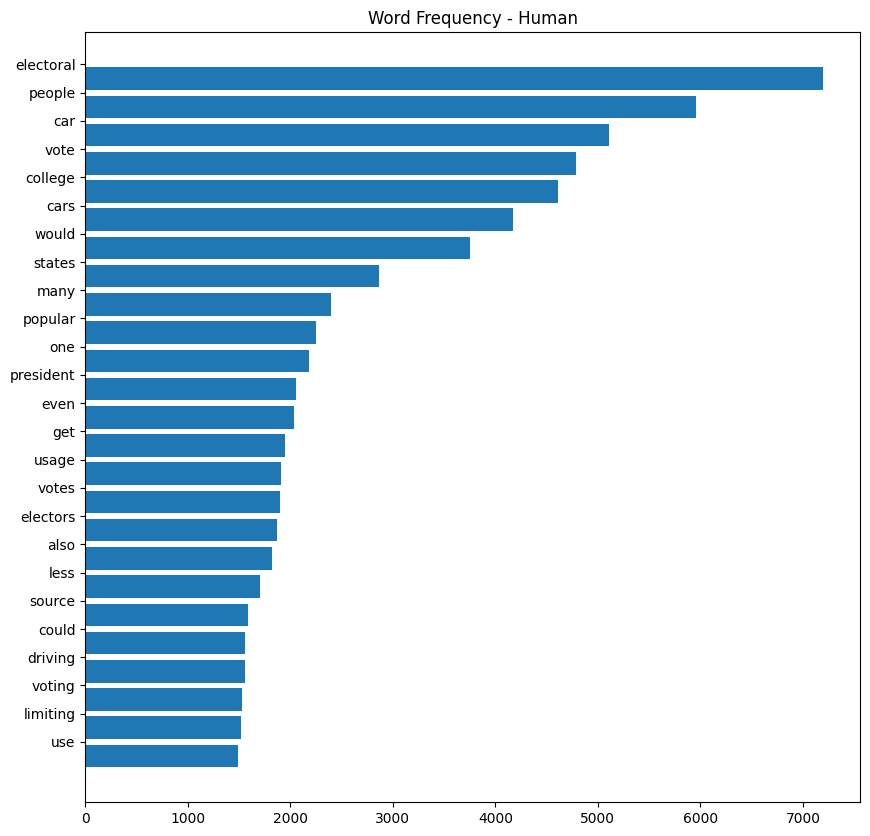

In [ ]:
def wordBarGraphFunction(data,column,title):
    topic_words = [z.lower() for y in
                   [x.split() for x in data[column] if isinstance(x, str)]
                   for z in y]
    word_count_dict = dict(Counter(topic_words))
    popular_words = sorted(word_count_dict, key = word_count_dict.get, reverse = True)
    popular_words_nonstop = [w for w in popular_words if w not in stopwords.words("english")]
    plt.barh(range(25), [word_count_dict[w] for w in reversed(popular_words_nonstop[0:25])])
    plt.yticks([x + 0.5 for x in range(25)], reversed(popular_words_nonstop[0:25]))
    plt.title(title)
    plt.show()

plt.figure(figsize=(10,10))
wordBarGraphFunction(data[data["generated"]==1],'text',"Word Frequency - AI")

plt.figure(figsize=(10,10))
wordBarGraphFunction(data[data["generated"]==0],'text',"Word Frequency - Human")


#Text Preprocessing

In [ ]:
def text_preprocess(text, rare_words=None):
    # Standardize letters (lowercasing)
    text = text.lower()

    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)

    # Tokenization
    tokens = word_tokenize(text)

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens_no_stopwords = [word for word in tokens if word not in stop_words]

    # Remove rare words, if any specified
    if rare_words:
        tokens_no_stopwords = [word for word in tokens_no_stopwords if word not in rare_words]

    # Stemming
    stemmer = PorterStemmer()
    stemmed_tokens = [stemmer.stem(word) for word in tokens_no_stopwords]

    return ' '.join(stemmed_tokens)


In [ ]:
data['processed_text'] = data['text'].apply(text_preprocess)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2762 entries, 0 to 2761
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   prompt_id       2762 non-null   int64 
 1   text            2762 non-null   object
 2   generated       2762 non-null   int64 
 3   word_count      2762 non-null   int64 
 4   processed_text  2762 non-null   object
dtypes: int64(3), object(2)
memory usage: 108.0+ KB


In [ ]:
data['processed_text']

0       world popul continu grow number car road led n...
1       dear state senat normal dont complaint person ...
2       human long complic relationship car earli 20th...
3       dear senat write today express strong support ...
4       vote presid unit state elect depend popular vo...
                              ...                        
2757    elector colleg consist con pro system unprogra...
2758    know well love breath fresh air go forest take...
2759    dear senat write today express support abolish...
2760    elect system chang popular vote elector colleg...
2761    secret car becom integr part live use get work...
Name: processed_text, Length: 2762, dtype: object

##Lexical & Syntactic Analysis

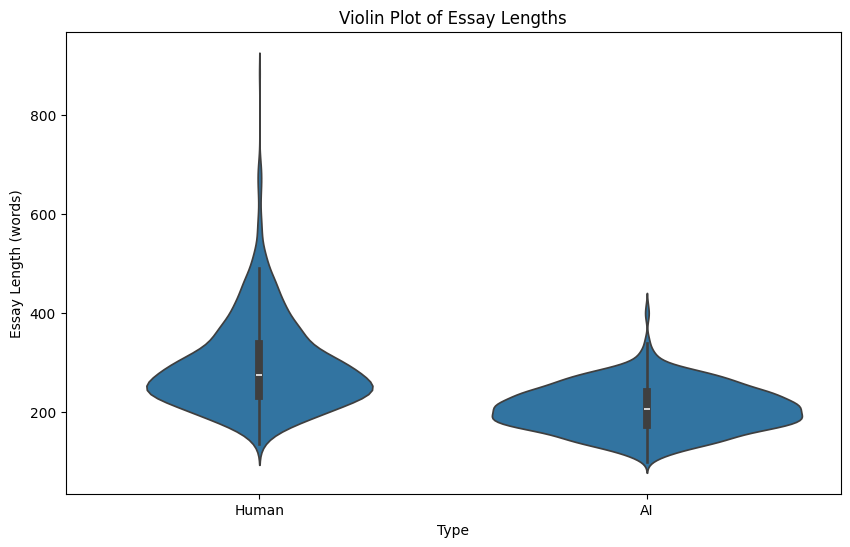

In [ ]:
##Essay length

def calculate_essay_length(data, text_column='processed_text'):

    # Calculate essay length as the number of words in the essay
    data['essay_length'] = data[text_column].apply(lambda x: len(x.split()))

    return data


data = calculate_essay_length(data)

# Split the DataFrame into AI and Human based on the 'generated' column
ai = data[data['generated'] == 1]
human = data[data['generated'] == 0]

# Visualize essay lengths for AI and Human essays
# Violin Plot
plt.figure(figsize=(10, 6))
sns.violinplot(x='generated', y='essay_length', data=data)
plt.xticks([0, 1], ['Human', 'AI'])
plt.title('Violin Plot of Essay Lengths')
plt.xlabel('Type')
plt.ylabel('Essay Length (words)')
plt.show()


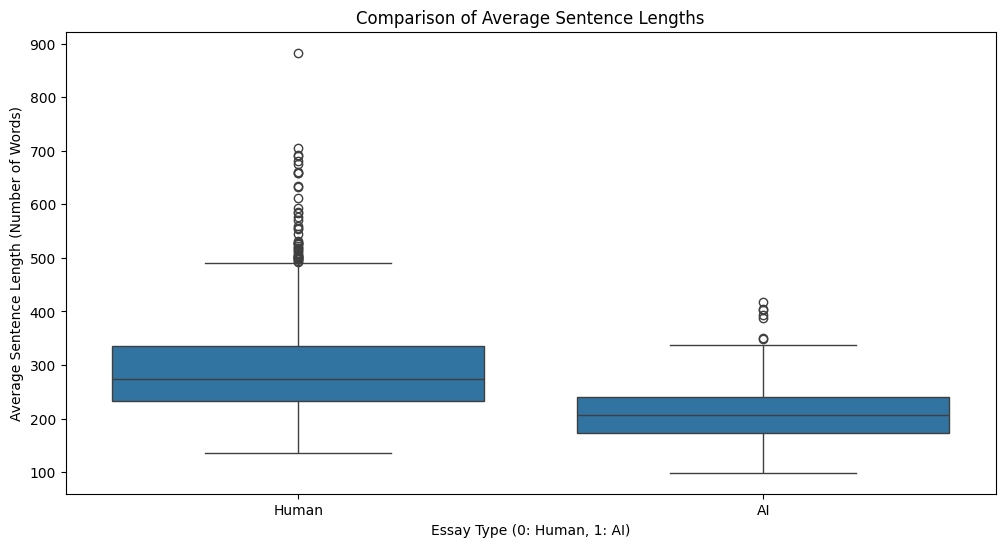

In [ ]:
##Average sentence length or sentence complexity
def calculate_avg_sentence_length(data, text_column='processed_text'):

    def avg_sentence_length(text):
        sentences = sent_tokenize(text)
        if len(sentences) == 0:
            return 0
        sentence_lengths = [len(word_tokenize(sentence)) for sentence in sentences]
        return np.mean(sentence_lengths)

    data['avg_sentence_length'] = data[text_column].apply(avg_sentence_length)

    return data
data = calculate_avg_sentence_length(data)
plt.figure(figsize=(12, 6))
sns.boxplot(x='generated', y='avg_sentence_length', data=data)
plt.title('Comparison of Average Sentence Lengths')
plt.xlabel('Essay Type (0: Human, 1: AI)')
plt.ylabel('Average Sentence Length (Number of Words)')
plt.xticks([0, 1], ['Human', 'AI'])
plt.show()

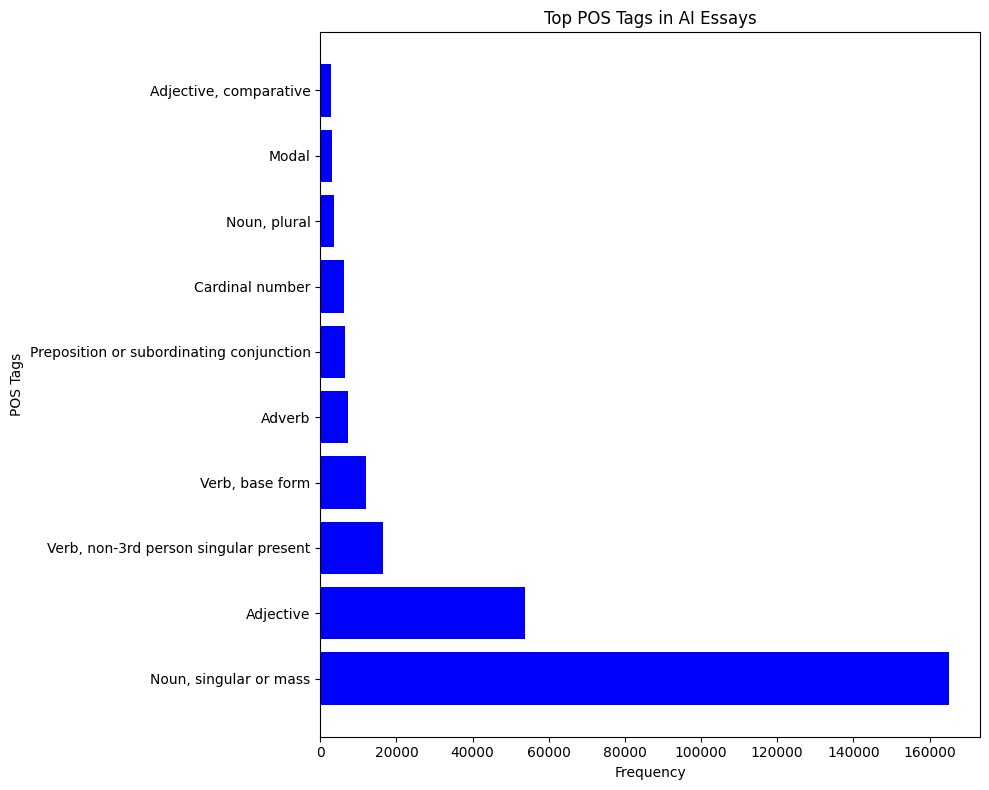

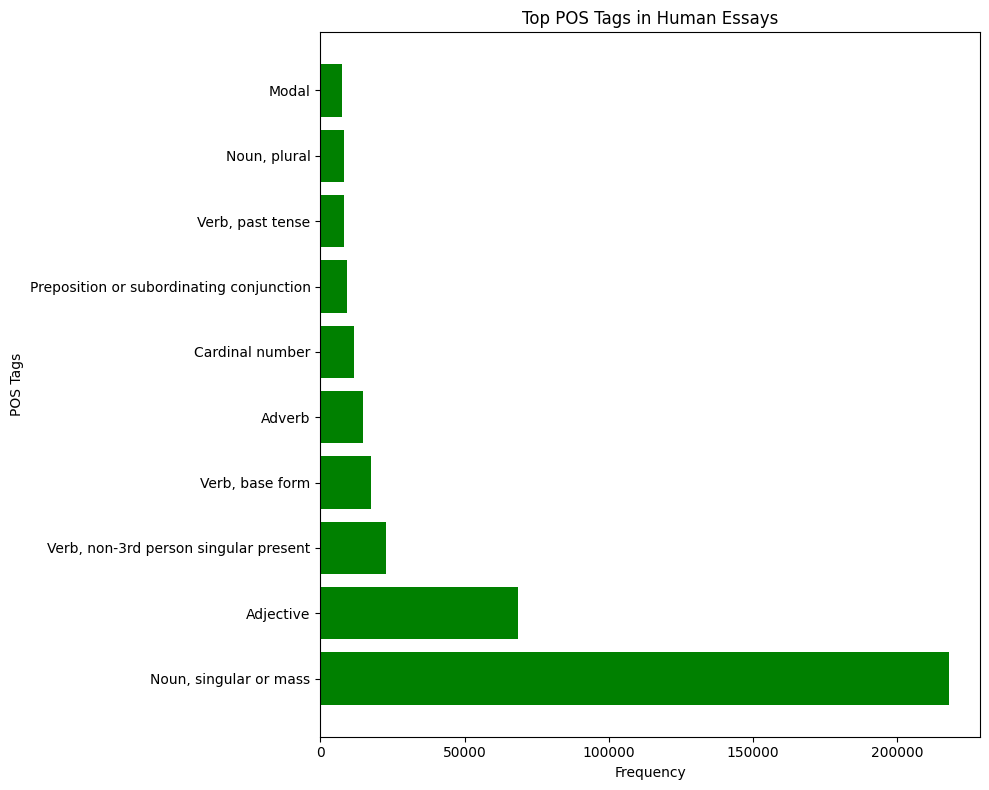

In [ ]:
##POS tagging
def pos_tagging(text):
    tokens = word_tokenize(text)
    tagged = pos_tag(tokens)
    tag_counts = Counter(tag for word, tag in tagged)
    return tag_counts


data['pos_tags'] = data['processed_text'].apply(pos_tagging)

# Aggregate POS tag counts for AI and human essays
ai_pos_counts = Counter()
human_pos_counts = Counter()

ai_essays = data[data['generated'] == 1]['pos_tags']
human_essays = data[data['generated'] == 0]['pos_tags']

for tags in ai_essays:
    ai_pos_counts.update(tags)

for tags in human_essays:
    human_pos_counts.update(tags)


#  top N tags for visualization
top_n = 10
ai_top_tags = ai_pos_counts.most_common(top_n)
human_top_tags = human_pos_counts.most_common(top_n)

# Unzipping the tags and counts
ai_tags, ai_counts = zip(*ai_top_tags)
human_tags, human_counts = zip(*human_top_tags)

tag_descriptions = {
    'CC': 'Coordinating conjunction',
    'CD': 'Cardinal number',
    'DT': 'Determiner',
    'EX': 'Existential there',
    'FW': 'Foreign word',
    'IN': 'Preposition or subordinating conjunction',
    'JJ': 'Adjective',
    'JJR': 'Adjective, comparative',
    'JJS': 'Adjective, superlative',
    'LS': 'List item marker',
    'MD': 'Modal',
    'NN': 'Noun, singular or mass',
    'NNS': 'Noun, plural',
    'NNP': 'Proper noun, singular',
    'NNPS': 'Proper noun, plural',
    'PDT': 'Predeterminer',
    'POS': 'Possessive ending',
    'PRP': 'Personal pronoun',
    'PRP$': 'Possessive pronoun',
    'RB': 'Adverb',
    'RBR': 'Adverb, comparative',
    'RBS': 'Adverb, superlative',
    'RP': 'Particle',
    'SYM': 'Symbol',
    'TO': 'to',
    'UH': 'Interjection',
    'VB': 'Verb, base form',
    'VBD': 'Verb, past tense',
    'VBG': 'Verb, gerund or present participle',
    'VBN': 'Verb, past participle',
    'VBP': 'Verb, non-3rd person singular present',
    'VBZ': 'Verb, 3rd person singular present',
    'WDT': 'Wh-determiner',
    'WP': 'Wh-pronoun',
    'WP$': 'Possessive wh-pronoun',
    'WRB': 'Wh-adverb'
}

# AI Essays POS Tags with Descriptions
ai_tags_descriptions = [tag_descriptions.get(tag, tag) for tag in ai_tags]

plt.figure(figsize=(10, 8))
plt.barh(ai_tags_descriptions, ai_counts, color='blue')
plt.title('Top POS Tags in AI Essays')
plt.xlabel('Frequency')
plt.ylabel('POS Tags')
plt.tight_layout()
plt.show()

# Human Essays POS Tags with Descriptions
human_tags_descriptions = [tag_descriptions.get(tag, tag) for tag in human_tags]

plt.figure(figsize=(10, 8))
plt.barh(human_tags_descriptions, human_counts, color='green')
plt.title('Top POS Tags in Human Essays')
plt.xlabel('Frequency')
plt.ylabel('POS Tags')
plt.tight_layout()
plt.show()


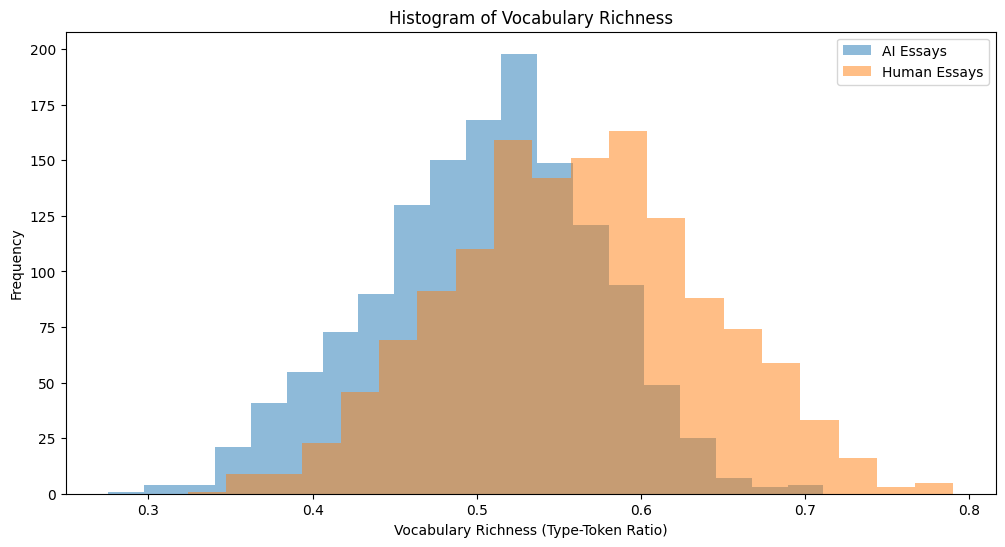

In [ ]:
#vocabulary richness
def calculate_vocabulary(data, text_column='processed_text'):

    def vocab(text):
        tokens = text.split()
        types = set(tokens)
        return len(types) / len(tokens) if tokens else 0

    data['vocab'] = data[text_column].apply(vocab)

    return data

data = calculate_vocabulary(data)

plt.figure(figsize=(12, 6))
plt.hist(data[data['generated'] == 1]['vocab'], bins=20, alpha=0.5, label='AI Essays')
plt.hist(data[data['generated'] == 0]['vocab'], bins=20, alpha=0.5, label='Human Essays')
plt.title('Histogram of Vocabulary Richness')
plt.xlabel('Vocabulary Richness (Type-Token Ratio)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

##Sentiment Analysis

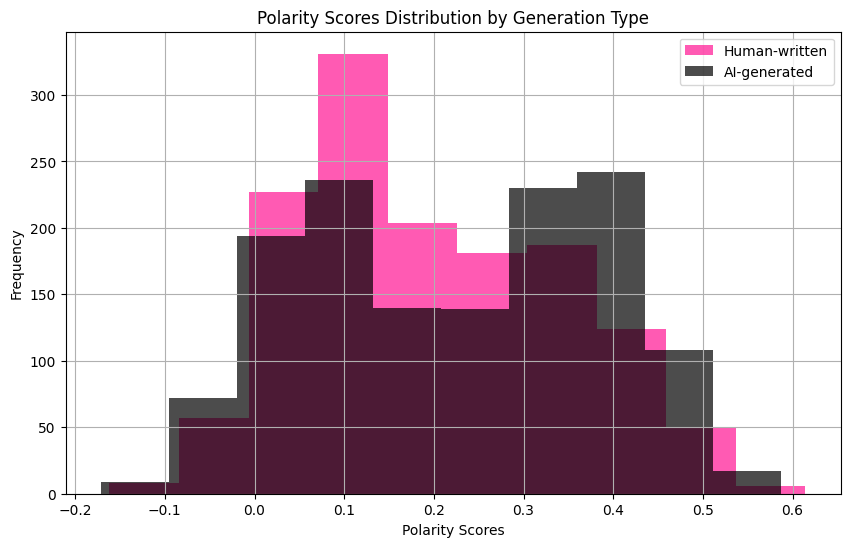

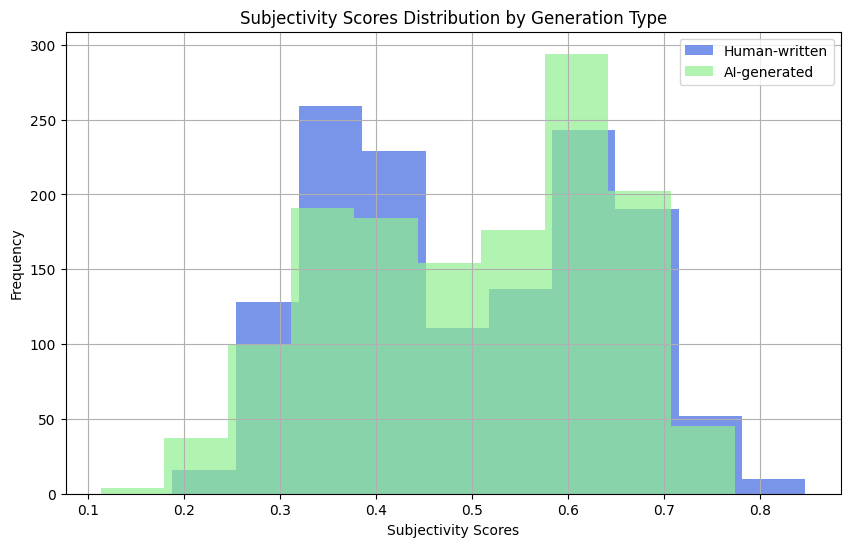

In [ ]:

def analyze_sentiment(data,text_column='processed_text'):
    def sentiment_scores(text):
        analysis = TextBlob(text).sentiment
        subjectivity = analysis.subjectivity
        polarity = analysis.polarity
        sentiment = 'Negative' if polarity < 0 else ('Neutral' if polarity == 0 else 'Positive')
        return sentiment, subjectivity, polarity
    results = data[text_column].apply(sentiment_scores)
    data[['sentiment', 'subjectivity', 'polarity']] = pd.DataFrame(results.tolist(), index=data.index)

    return data
data = analyze_sentiment(data)

#Plotting histograms for polarity scores for each group
plt.figure(figsize=(10, 6))

#Human written data (group 0)
plt.hist(data[data['generated'] == 0]['polarity'], bins=10, color='deeppink', alpha=0.7, label='Human-written')

#AI generated data (group 1)
plt.hist(data[data['generated'] == 1]['polarity'], bins=10, color='black', alpha=0.7, label='AI-generated')

# Adding labels and title
plt.title('Polarity Scores Distribution by Generation Type')
plt.xlabel('Polarity Scores')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

##Subjectivity
plt.figure(figsize=(10, 6))

#Human-written data (group 0)
plt.hist(data[data['generated'] == 0]['subjectivity'], bins=10, color='royalblue', alpha=0.7, label='Human-written')

# AI-generated data (group 1)
plt.hist(data[data['generated'] == 1]['subjectivity'], bins=10, color='lightgreen', alpha=0.7, label='AI-generated')

# Adding labels and title
plt.title('Subjectivity Scores Distribution by Generation Type')
plt.xlabel('Subjectivity Scores')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()



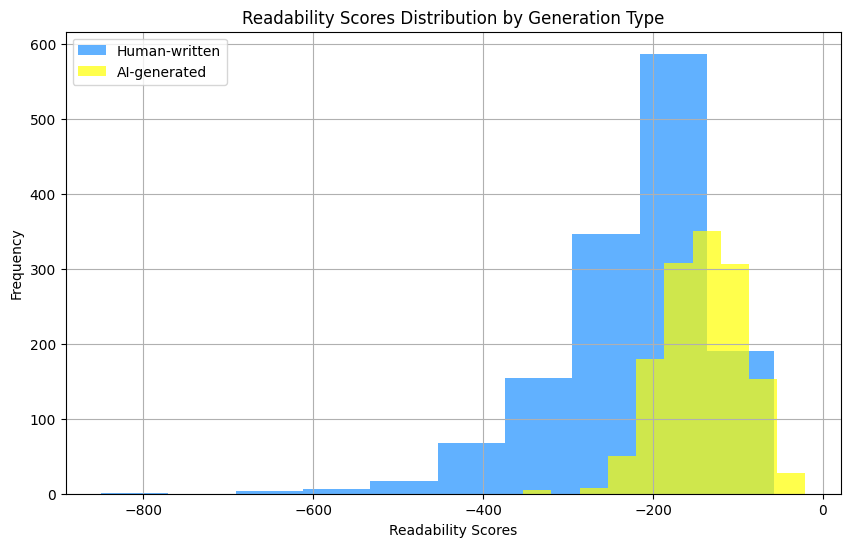

In [ ]:
#Readability Scores
def calculate_readability(data,text_column='processed_text'):
  def Readability_Scores(text):
    return textstat.flesch_reading_ease(text)
  data['readability']= data[text_column].apply(Readability_Scores)

  return data
data = calculate_readability(data)

# Plotting histograms for each group
plt.figure(figsize=(10, 6))

# Human-written data (group 0)
plt.hist(data[data['generated'] == 0]['readability'], bins=10, color='dodgerblue', alpha=0.7, label='Human-written')

# AI-generated data (group 1)
plt.hist(data[data['generated'] == 1]['readability'], bins=10, color='yellow', alpha=0.7, label='AI-generated')

# Adding labels and title
plt.title('Readability Scores Distribution by Generation Type')
plt.xlabel('Readability Scores')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

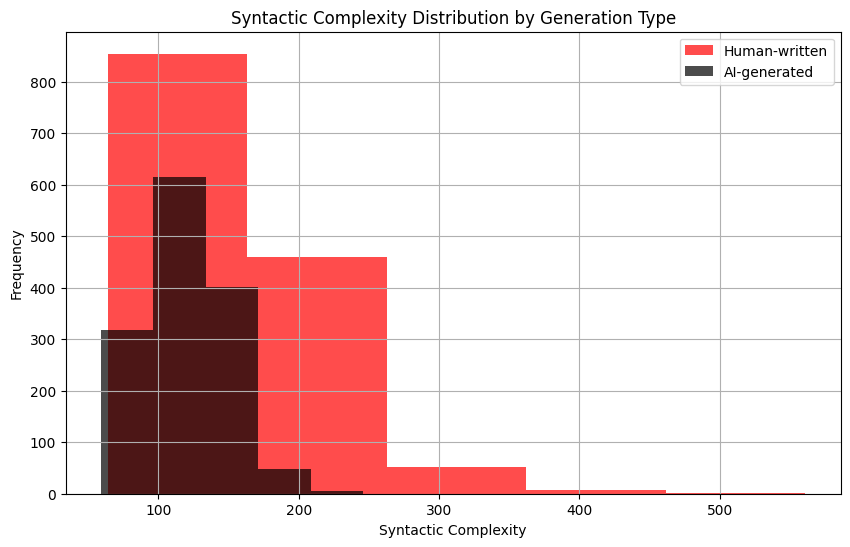

In [ ]:
def calculate_syntactic_complexity(data,text_column='processed_text'):
  def syntactic_complexity(text):
    tokens = word_tokenize(text)
    pos_tags = pos_tag(tokens)
    grammar = "NP: {<DT>?<JJ>*<NN>}"
    cp = RegexpParser(grammar)
    result = cp.parse(pos_tags)
    num_phrases = sum(1 for _ in result.subtrees())
    return num_phrases
  data['syntactic_complexity']=data[text_column].apply(syntactic_complexity)
  return data
data = calculate_syntactic_complexity(data)

# Plotting histograms for polarity scores for each group
plt.figure(figsize=(10, 6))

# Human-written data (group 0)
plt.hist(data[data['generated'] == 0]['syntactic_complexity'], bins=5, color='red', alpha=0.7, label='Human-written')

# AI-generated data (group 1)
plt.hist(data[data['generated'] == 1]['syntactic_complexity'], bins=5, color='black', alpha=0.7, label='AI-generated')

# Adding labels and title
plt.title('Syntactic Complexity Distribution by Generation Type')
plt.xlabel('Syntactic Complexity')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

Semantic Analysis

In [ ]:
nltk.download('words')

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


True

Coherence and Consistency Statistics:
+-----------+-------------------+--------------------+
| generated |    word_count     |       vocab        |
+-----------+-------------------+--------------------+
|     0     | 556.7687272727272 | 0.5017052507963657 |
|     1     | 383.8139870223504 | 0.4682709258990161 |
+-----------+-------------------+--------------------+


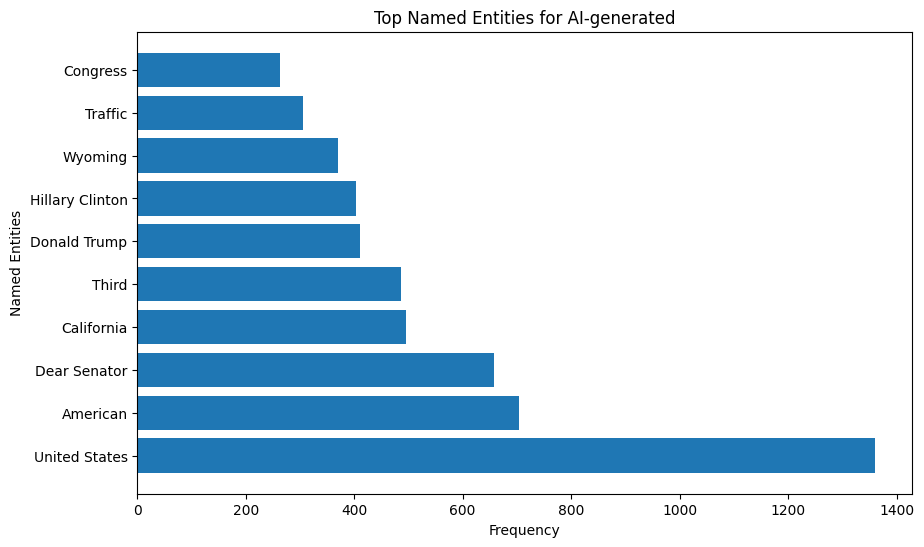

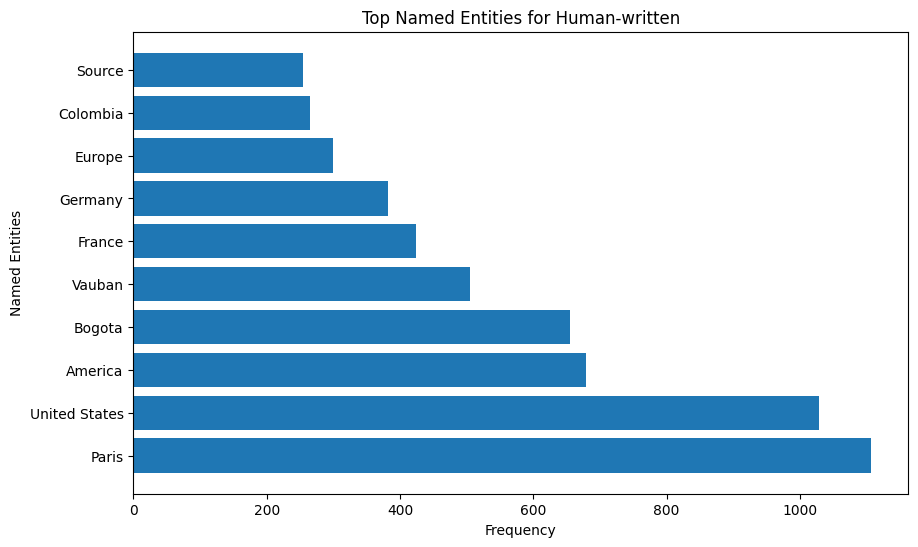


Counts of Named Entities:
                 Generated 0  Generated 1
AAA                      0.0          1.0
AFCCIO                   1.0          0.0
AFL                      1.0          0.0
AFLCIO                  29.0          0.0
AI Gprethanks            1.0          0.0
...                      ...          ...
trafficS3 P20            1.0          0.0
trulyMs                  1.0          0.0
unAmerican               1.0          0.0
votesIn Defense          1.0          0.0
votingPoshner            1.0          0.0

[1752 rows x 2 columns]


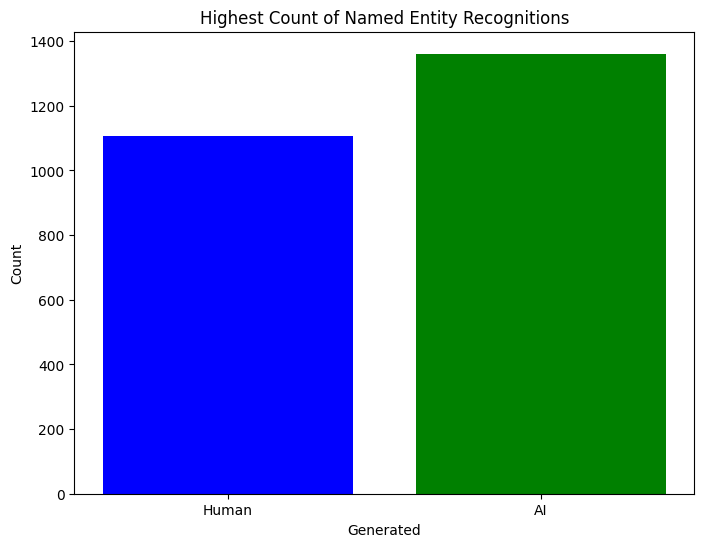

   prompt_id                                               text  generated  \
0          0  As the world's population continues to grow, s...          1   
1          1  Dear State Senator, While I normally don't hav...          0   
2          0  Humans have a long and complicated relationshi...          1   
3          1  Dear Senator,\n\nI am writing to you today to ...          1   
4          1  For the vote for the president of the United S...          0   

   word_count                                     processed_text  \
0         457  world popul continu grow number car road led n...   
1         401  dear state senat normal dont complaint person ...   
2         381  human long complic relationship car earli 20th...   
3         482  dear senat write today express strong support ...   
4         461  vote presid unit state elect depend popular vo...   

   essay_length  avg_sentence_length  \
0           242                242.0   
1           196                196.0   
2 

In [ ]:
# Function to perform Named Entity Recognition (NER)
def extract_named_entities(text):
    sentences = nltk.sent_tokenize(text)
    tokenized_sentences = [nltk.word_tokenize(sentence) for sentence in sentences]
    tagged_sentences = [nltk.pos_tag(sentence) for sentence in tokenized_sentences]
    chunked_sentences = nltk.ne_chunk_sents(tagged_sentences, binary=True)

    named_entities = []
    for chunked_sentence in chunked_sentences:
        for subtree in chunked_sentence:
            if type(subtree) == nltk.tree.Tree:
                entity = " ".join([token for token, pos in subtree.leaves()])
                entity_type = subtree.label()
                named_entities.append(entity)

    return named_entities

# Function to calculate coherence and consistency metrics
def calculate_coherence_consistency(data):
    # For demonstration purposes, let's assume coherence and consistency are based on word count and vocabulary richness.
    data['word_count'] = data['text'].apply(lambda x: len(x.split()))
    data['vocab'] = data['text'].apply(lambda x: len(set(x.split())) / len(x.split()))

    # Group by 'generated' column (0 for human-written, 1 for AI-generated) and calculate mean coherence and consistency
    coherence_consistency_stats = data.groupby('generated')[['word_count', 'vocab']].mean()

    return coherence_consistency_stats



def extract_and_aggregate_named_entities(data):
    ai_named_entities = []
    human_named_entities = []

    for index, row in data.iterrows():
        named_entities = extract_named_entities(row['text'])
        if named_entities is not None:
            if row['generated'] == 1:
                ai_named_entities.extend(named_entities)
            else:
                human_named_entities.extend(named_entities)

    return ai_named_entities, human_named_entities


# Function to visualize the most common named entities
def visualize_most_common_named_entities(named_entities, label):
    if not named_entities:
        print(f"No named entities found for {label}.")
        return

    # Count the occurrences of each named entity
    entity_counts = Counter(named_entities)

    # Plot the top N named entities
    top_n = 10
    top_entities = entity_counts.most_common(top_n)
    entities, counts = zip(*top_entities)

    plt.figure(figsize=(10, 6))
    plt.barh(entities, counts)
    plt.xlabel('Frequency')
    plt.ylabel('Named Entities')
    plt.title(f'Top Named Entities for {label}')
    plt.show()



# Calculate coherence and consistency
coherence_consistency_stats = calculate_coherence_consistency(data)
print("Coherence and Consistency Statistics:")
print(tabulate(coherence_consistency_stats, headers='keys', tablefmt='pretty'))

# Aggregate named entities for AI-generated and human-written essays
ai_named_entities, human_named_entities = extract_and_aggregate_named_entities(data)

# Visualize the most common named entities for AI-generated and human-written essays
visualize_most_common_named_entities(ai_named_entities, "AI-generated")
visualize_most_common_named_entities(human_named_entities, "Human-written")

# Aggregate counts of named entities for AI-generated and human-written essays
ai_counts = pd.Series(ai_named_entities).value_counts()
human_counts = pd.Series(human_named_entities).value_counts()

# Create a DataFrame to display the counts of named entities for generated 0 and generated 1
counts_df = pd.DataFrame({'Generated 0': human_counts, 'Generated 1': ai_counts}).fillna(0)

# Display the DataFrame
print("\nCounts of Named Entities:")
print(counts_df)

# Count the occurrences of each named entity for AI-generated and human-written essays
ai_entity_counts = Counter(ai_named_entities)
human_entity_counts = Counter(human_named_entities)

# Get the highest count of NERs for each group
ai_highest_count = ai_entity_counts.most_common(1)[0][1]
human_highest_count = human_entity_counts.most_common(1)[0][1]

# Plot the highest count of NERs for each group
plt.figure(figsize=(8, 6))
plt.bar(["Human", "AI"], [human_highest_count, ai_highest_count], color=['blue', 'green'])
plt.title('Highest Count of Named Entity Recognitions')
plt.xlabel('Generated')
plt.ylabel('Count')
plt.show()
# Add a new column to the dataframe with named entities for each row
data['named_entities'] = data['text'].apply(lambda x: extract_named_entities(x))

# Display the first few rows to verify the addition
print(data.head())


In [ ]:
import pandas as pd
import ast

# Function to count the occurrences of named entities and POS tags
def count_occurrences(column):
    # Convert the string representation of list to an actual list
    items_list = [ast.literal_eval(item) if isinstance(item, str) else item for item in column]
    # Count the occurrences of each item in the list
    counts = [len(items) for items in items_list]
    return counts

# Apply the count_occurrences function to the 'named_entities' and 'pos_tags' columns
data['named_entities_'] = count_occurrences(data['named_entities'])
data['pos_tags_'] = count_occurrences(data['pos_tags'])



In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2762 entries, 0 to 2761
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   prompt_id             2762 non-null   int64  
 1   text                  2762 non-null   object 
 2   generated             2762 non-null   int64  
 3   word_count            2762 non-null   int64  
 4   processed_text        2762 non-null   object 
 5   essay_length          2762 non-null   int64  
 6   avg_sentence_length   2762 non-null   float64
 7   pos_tags              2762 non-null   object 
 8   vocab                 2762 non-null   float64
 9   sentiment             2762 non-null   object 
 10  subjectivity          2762 non-null   float64
 11  polarity              2762 non-null   float64
 12  readability           2762 non-null   float64
 13  syntactic_complexity  2762 non-null   int64  
 14  named_entities        2762 non-null   object 
 15  named_entities_      

#TF-IDF

In [ ]:
data['processed_text']

0       world popul continu grow number car road led n...
1       dear state senat normal dont complaint person ...
2       human long complic relationship car earli 20th...
3       dear senat write today express strong support ...
4       vote presid unit state elect depend popular vo...
                              ...                        
2757    elector colleg consist con pro system unprogra...
2758    know well love breath fresh air go forest take...
2759    dear senat write today express support abolish...
2760    elect system chang popular vote elector colleg...
2761    secret car becom integr part live use get work...
Name: processed_text, Length: 2762, dtype: object

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

ptext = data['processed_text']
#tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 1))
tfidf_vectorizer = TfidfVectorizer(smooth_idf=True)
tfidf_matrix = tfidf_vectorizer.fit_transform(ptext)

feature_names = tfidf_vectorizer.get_feature_names_out()
print(tfidf_matrix)
print("Feature names:", feature_names)  # print first 10 features
print("TF-IDF Matrix shape:", tfidf_matrix.shape)

  (0, 2909)	0.03626006887876498
  (0, 2835)	0.03343280576330835
  (0, 8558)	0.09680104494758246
  (0, 5143)	0.08973844506384156
  (0, 5853)	0.0813600929139088
  (0, 5298)	0.05817980199126519
  (0, 9309)	0.025538721942771715
  (0, 3509)	0.05162693562681057
  (0, 12482)	0.1018113388638749
  (0, 1169)	0.03616011257541092
  (0, 5253)	0.02613160779886397
  (0, 12588)	0.06287638438525953
  (0, 7144)	0.03136344049586875
  (0, 12077)	0.02441301518514198
  (0, 5442)	0.05956826702449545
  (0, 2373)	0.265719778141621
  (0, 3517)	0.04945973823433597
  (0, 12363)	0.02563190291286412
  (0, 6695)	0.04926686417228387
  (0, 1702)	0.053603257178376544
  (0, 1946)	0.0418286446550746
  (0, 11572)	0.05070842160221245
  (0, 9131)	0.05437657665145017
  (0, 12647)	0.08203803226420472
  (0, 1211)	0.028037015540384538
  :	:
  (2761, 7389)	0.12592332384363955
  (2761, 11383)	0.03300648149389193
  (2761, 8389)	0.013299602314501361
  (2761, 9940)	0.15499234440341336
  (2761, 4796)	0.036788838243224244
  (2761, 938

In [ ]:
print("Feature names:", feature_names)

Feature names: ['00' '000' '000000001' ... 'zone' 'zoom' 'zroom']


In [ ]:
for i in range(tfidf_matrix.shape[0]):  # Iterate over rows
    row = tfidf_matrix.getrow(i)
    non_zero_columns = row.nonzero()[1]  # Get non-zero column indices
    non_zero_values = row.data  # Access non-zero values directly

    # Example of working with non-zero elements
    for col_index, value in zip(non_zero_columns, non_zero_values):
        print(f"Row {i}, Column {col_index}, Value {value}")

Streaming output truncated to the last 5000 lines.
Row 2725, Column 7976, Value 0.059104840804590386
Row 2725, Column 12744, Value 0.058469917463446736
Row 2725, Column 9295, Value 0.08978084784013472
Row 2725, Column 8224, Value 0.05760561389433618
Row 2725, Column 4421, Value 0.027902503584201436
Row 2725, Column 7867, Value 0.04526612967600575
Row 2725, Column 6788, Value 0.11707315780246098
Row 2725, Column 7468, Value 0.08344673346518952
Row 2725, Column 3144, Value 0.03275935110680174
Row 2725, Column 876, Value 0.0407442149505909
Row 2725, Column 3262, Value 0.0723835296857704
Row 2725, Column 5277, Value 0.05995520033445647
Row 2725, Column 4273, Value 0.046824775550755086
Row 2725, Column 6855, Value 0.027244186708887792
Row 2725, Column 12736, Value 0.04501277212152177
Row 2725, Column 2353, Value 0.09209183026026924
Row 2725, Column 3818, Value 0.13741103803636745
Row 2725, Column 7708, Value 0.07340269298393627
Row 2725, Column 5298, Value 0.03250616924910048
Row 2725, Colu

In [ ]:
min_values = []
max_values = []
mean_values = []
mode_values = []

for i in range(tfidf_matrix.shape[0]):
    row = tfidf_matrix.getrow(i)
    non_zero_values = row.data

    if non_zero_values.size > 0:
        min_val = np.min(non_zero_values)
        max_val = np.max(non_zero_values)
        mean_val = np.mean(non_zero_values)

    else:
        min_val = max_val = mean_val = 0

    min_values.append(min_val)
    max_values.append(max_val)
    mean_values.append(mean_val)


da1 = {
    'Row': range(tfidf_matrix.shape[0]),
    'Min': min_values,
    'Max': max_values,
    'Mean': mean_values
}

df1 = pd.DataFrame(da1)

df1.head()

,Row,Min,Max,Mean
0,0,0.019271,0.416433,0.078376
1,1,0.024818,0.243371,0.075997
2,2,0.017309,0.394052,0.068879
3,3,0.019626,0.387441,0.071906
4,4,0.018515,0.393212,0.074239


In [ ]:
#X = np.array(tfidf_df)

In [ ]:
df1.head()

,Row,Min,Max,Mean
0,0,0.019271,0.416433,0.078376
1,1,0.024818,0.243371,0.075997
2,2,0.017309,0.394052,0.068879
3,3,0.019626,0.387441,0.071906
4,4,0.018515,0.393212,0.074239


In [ ]:
d = pd.concat([data,df1],axis=1)

In [ ]:
d.head()

,prompt_id,text,generated,word_count,processed_text,essay_length,avg_sentence_length,pos_tags,vocab,sentiment,...,polarity,readability,syntactic_complexity,named_entities,named_entities_,pos_tags_,Row,Min,Max,Mean
0,0,"As the world's population continues to grow, s...",1,457,world popul continu grow number car road led n...,242,242.0,"{'NN': 140, 'VB': 12, 'VBD': 1, 'JJS': 4, 'RB'...",0.378556,Positive,...,0.052500,-174.16,141,[],0,15,0,0.019271,0.416433,0.078376
1,1,"Dear State Senator, While I normally don't hav...",0,401,dear state senat normal dont complaint person ...,196,196.0,"{'JJ': 40, 'NN': 91, 'VBN': 3, 'IN': 4, 'JJS':...",0.551122,Positive,...,0.121839,-119.01,92,"[Dear State Senator, Please, Obama, America, N...",6,13,1,0.024818,0.243371,0.075997
2,0,Humans have a long and complicated relationshi...,1,381,human long complic relationship car earli 20th...,238,238.0,"{'JJ': 48, 'RB': 4, 'NN': 133, 'CD': 1, 'VBN':...",0.467192,Positive,...,0.045455,-170.10,134,"[Traffic, Third, Urban, Fourth, Fifth]",5,15,2,0.017309,0.394052,0.068879
3,1,"Dear Senator,\n\nI am writing to you today to ...",1,482,dear senat write today express strong support ...,232,232.0,"{'JJ': 51, 'NN': 119, 'VBP': 14, 'RBR': 2, 'VB...",0.429461,Positive,...,0.495908,-172.47,120,"[Dear Senator, Congress, George, Al Gore, Dona...",8,15,3,0.019626,0.387441,0.071906
4,1,For the vote for the president of the United S...,0,461,vote presid unit state elect depend popular vo...,227,227.0,"{'NN': 123, 'JJ': 40, 'VBP': 12, 'IN': 6, 'CD'...",0.459870,Positive,...,0.214286,-158.94,124,"[United States, United States, United States]",3,13,4,0.018515,0.393212,0.074239


In [ ]:
"""
CSV = d.drop(['pos_tags', 'named_entities'], axis=1)

"""
filename = 'data.csv'
# Extracting the DataFrame to a CSV file
d.to_csv(filename, index=False)


In [ ]:
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2762 entries, 0 to 2761
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   prompt_id             2762 non-null   int64  
 1   text                  2762 non-null   object 
 2   generated             2762 non-null   int64  
 3   word_count            2762 non-null   int64  
 4   processed_text        2762 non-null   object 
 5   essay_length          2762 non-null   int64  
 6   avg_sentence_length   2762 non-null   float64
 7   pos_tags              2762 non-null   object 
 8   vocab                 2762 non-null   float64
 9   sentiment             2762 non-null   object 
 10  subjectivity          2762 non-null   float64
 11  polarity              2762 non-null   float64
 12  readability           2762 non-null   float64
 13  syntactic_complexity  2762 non-null   int64  
 14  named_entities        2762 non-null   object 
 15  named_entities_      

#Correlation

                      word_count  essay_length     vocab  subjectivity  \
word_count              1.000000      0.967603 -0.202015     -0.187652   
essay_length            0.967603      1.000000 -0.164084     -0.309031   
vocab                  -0.202015     -0.164084  1.000000     -0.088739   
subjectivity           -0.187652     -0.309031 -0.088739      1.000000   
polarity               -0.216820     -0.324297 -0.031857      0.793397   
readability            -0.959357     -0.996123  0.185580      0.304076   
syntactic_complexity    0.909941      0.966325 -0.192661     -0.335852   
named_entities_         0.559587      0.571505  0.257304     -0.048745   
pos_tags_               0.585260      0.560879  0.097420     -0.119497   
generated              -0.570799     -0.518497 -0.289922      0.012332   
Min                    -0.750007     -0.778954  0.235823      0.243366   
Max                    -0.010650      0.026274 -0.333862      0.117781   
Mean                   -0.850886     -

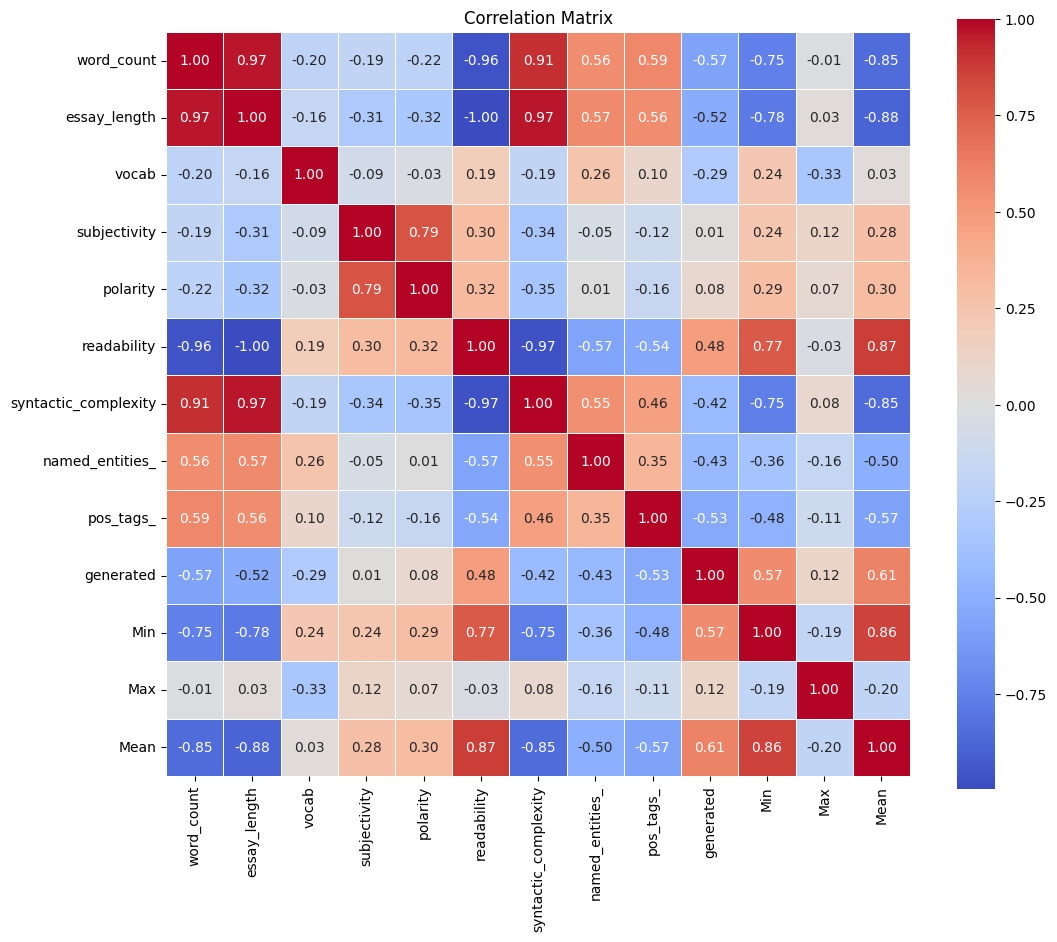

In [ ]:
import numpy as np
np.random.seed(1234)
# Selecting only the numeric columns for correlation
numeric_columns = [
    'word_count', 'essay_length', 'vocab',
    'subjectivity', 'polarity', 'readability',
    'syntactic_complexity', 'named_entities_', 'pos_tags_','generated','Min','Max','Mean'
]

# Compute the correlation matrix for the selected columns
correlation_matrix = d[numeric_columns].corr()
print(correlation_matrix)


import seaborn as sns
import matplotlib.pyplot as plt

# Set the matplotlib figure
plt.figure(figsize=(12, 10))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=.5)

plt.title('Correlation Matrix')

# Show plot
plt.show()

In [ ]:
print(correlation_matrix)

                      word_count  essay_length     vocab  subjectivity  \
word_count              1.000000      0.967603 -0.202015     -0.187652   
essay_length            0.967603      1.000000 -0.164084     -0.309031   
vocab                  -0.202015     -0.164084  1.000000     -0.088739   
subjectivity           -0.187652     -0.309031 -0.088739      1.000000   
polarity               -0.216820     -0.324297 -0.031857      0.793397   
readability            -0.959357     -0.996123  0.185580      0.304076   
syntactic_complexity    0.909941      0.966325 -0.192661     -0.335852   
named_entities_         0.559587      0.571505  0.257304     -0.048745   
pos_tags_               0.585260      0.560879  0.097420     -0.119497   
generated              -0.570799     -0.518497 -0.289922      0.012332   
Min                    -0.750007     -0.778954  0.235823      0.243366   
Max                    -0.010650      0.026274 -0.333862      0.117781   
Mean                   -0.850886     -

In [ ]:
#data.info()

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2762 entries, 0 to 2761
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   prompt_id             2762 non-null   int64  
 1   text                  2762 non-null   object 
 2   generated             2762 non-null   int64  
 3   word_count            2762 non-null   int64  
 4   processed_text        2762 non-null   object 
 5   essay_length          2762 non-null   int64  
 6   avg_sentence_length   2762 non-null   float64
 7   pos_tags              2762 non-null   object 
 8   vocab                 2762 non-null   float64
 9   sentiment             2762 non-null   object 
 10  subjectivity          2762 non-null   float64
 11  polarity              2762 non-null   float64
 12  readability           2762 non-null   float64
 13  syntactic_complexity  2762 non-null   int64  
 14  named_entities        2762 non-null   object 
 15  named_entities_      

## Feature Importance Using Random Forest

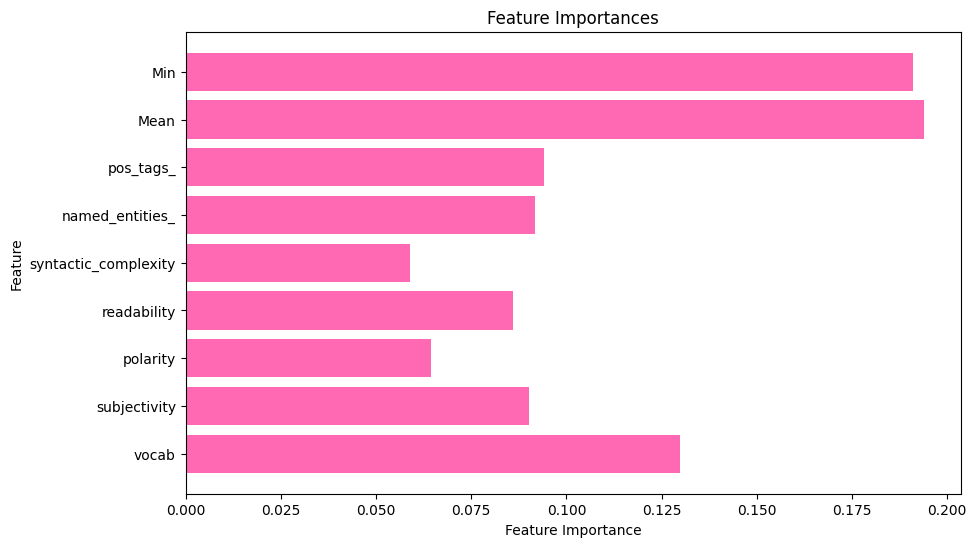

In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot as plt

np.random.seed(1234)

features_columns = ['vocab','subjectivity', 'polarity',
                    'readability', 'syntactic_complexity',
                    'named_entities_', 'pos_tags_','Mean','Min']
X = d[features_columns]
y = d['generated']


rf = RandomForestClassifier(n_estimators=100)

rf.fit(X, y)

feature_importances = rf.feature_importances_

plt.figure(figsize=(10, 6))
plt.barh(features_columns, feature_importances, color="hotpink")
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.show()


In [ ]:
feature_data = pd.DataFrame({'feature': features_columns, 'importance': feature_importances})

In [ ]:
sorted_feature_data = feature_data.sort_values(by='importance', ascending=False)
sorted_feature_data.reset_index(drop=True, inplace=True)
sorted_feature_data.index += 1
sorted_feature_data

,feature,importance
1,Mean,0.193859
2,Min,0.191134
3,vocab,0.129850
4,pos_tags_,0.093991
5,named_entities_,0.091685
6,subjectivity,0.090111
7,readability,0.085964
8,polarity,0.064551
9,syntactic_complexity,0.058855


In [ ]:
data.head()

,prompt_id,text,generated,word_count,processed_text,essay_length,avg_sentence_length,pos_tags,vocab,sentiment,subjectivity,polarity,readability,syntactic_complexity,named_entities,named_entities_,pos_tags_
0,0,"As the world's population continues to grow, s...",1,457,world popul continu grow number car road led n...,242,242.0,"{'NN': 140, 'VB': 12, 'VBD': 1, 'JJS': 4, 'RB'...",0.378556,Positive,0.543333,0.052500,-174.16,141,[],0,15
1,1,"Dear State Senator, While I normally don't hav...",0,401,dear state senat normal dont complaint person ...,196,196.0,"{'JJ': 40, 'NN': 91, 'VBN': 3, 'IN': 4, 'JJS':...",0.551122,Positive,0.533292,0.121839,-119.01,92,"[Dear State Senator, Please, Obama, America, N...",6,13
2,0,Humans have a long and complicated relationshi...,1,381,human long complic relationship car earli 20th...,238,238.0,"{'JJ': 48, 'RB': 4, 'NN': 133, 'CD': 1, 'VBN':...",0.467192,Positive,0.214394,0.045455,-170.10,134,"[Traffic, Third, Urban, Fourth, Fifth]",5,15
3,1,"Dear Senator,\n\nI am writing to you today to ...",1,482,dear senat write today express strong support ...,232,232.0,"{'JJ': 51, 'NN': 119, 'VBP': 14, 'RBR': 2, 'VB...",0.429461,Positive,0.702679,0.495908,-172.47,120,"[Dear Senator, Congress, George, Al Gore, Dona...",8,15
4,1,For the vote for the president of the United S...,0,461,vote presid unit state elect depend popular vo...,227,227.0,"{'NN': 123, 'JJ': 40, 'VBP': 12, 'IN': 6, 'CD'...",0.459870,Positive,0.735979,0.214286,-158.94,124,"[United States, United States, United States]",3,13


#Model Building


In [ ]:
np.random.seed(101)

##Machine Learning Models


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np

Target variable and selected features

In [ ]:
feature_columns = ['Mean', 'word_count', 'vocab', 'Min', 'subjectivity',
                   'named_entities_', 'syntactic_complexity']
X = d[feature_columns]
y = d['generated']


Splitting the dataset by train and test methods

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Logistic Regression Pipeline
lr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(max_iter=10000))
])

# SVM Pipeline
svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC())
])

# Train the Logistic Regression model
lr_pipeline.fit(X_train, y_train)

# Train the SVM model
svm_pipeline.fit(X_train, y_train)

# Making predictions
y_pred_lr = lr_pipeline.predict(X_test)
y_pred_svm = svm_pipeline.predict(X_test)

# Evaluation
lr_acc = accuracy_score(y_test, y_pred_lr)
svm_acc = accuracy_score(y_test, y_pred_svm)

lr_report = classification_report(y_test, y_pred_lr)
svm_report = classification_report(y_test, y_pred_svm)

In [ ]:
print("logistic Regression")
print(lr_report)
print("Support Vector Machine")
print(svm_report)

logistic Regression
              precision    recall  f1-score   support

           0       0.93      0.92      0.93       282
           1       0.92      0.93      0.92       271

    accuracy                           0.92       553
   macro avg       0.92      0.92      0.92       553
weighted avg       0.92      0.92      0.92       553

Support Vector Machine
              precision    recall  f1-score   support

           0       0.96      0.93      0.94       282
           1       0.93      0.96      0.94       271

    accuracy                           0.94       553
   macro avg       0.94      0.94      0.94       553
weighted avg       0.94      0.94      0.94       553



In [ ]:
#XGBoost
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

model = XGBClassifier(objective='binary:logistic',use_label_encoder=False)
model.fit(X_train, y_train)
y_val_pred = model.predict(X_test)
print(classification_report(y_test, y_val_pred))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95       282
           1       0.95      0.94      0.95       271

    accuracy                           0.95       553
   macro avg       0.95      0.95      0.95       553
weighted avg       0.95      0.95      0.95       553



In [ ]:
# Extracting default parameters for Logistic Regression
lr_default_params = lr_pipeline.named_steps['lr'].get_params()
print("Logistic Regression default parameters:")
print(lr_default_params)

# Extracting default parameters for SVM
svm_default_params = svm_pipeline.named_steps['svm'].get_params()
print("\nSVM default parameters:")
print(svm_default_params)

# Extracting default parameters for XGBoost
xgb_default_params = model.get_params()
print("XGBoost default parameters:")
print(xgb_default_params)




Logistic Regression default parameters:
{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 10000, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}

SVM default parameters:
{'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}
XGBoost default parameters:
{'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'grow_policy': None, 'importance_type': None,

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid_lr = {
    'lr__C': [0.01, 0.1, 1, 10, 100],
    'lr__solver': ['liblinear', 'sag','saga']
}

param_grid_svm = {
    'svm__C': [0.1, 1, 10, 100],
    'svm__kernel': ['linear', 'rbf', 'poly','sigmoid'],
    'svm__gamma': ['scale', 'auto']
}

param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [4, 6, 8],
    'subsample': [0.6, 0.8, 1.0]
}


# Initialize GridSearchCV

grid_search_lr = GridSearchCV(lr_pipeline, param_grid_lr, cv=5, scoring='precision', n_jobs=-1)

grid_search_svm = GridSearchCV(svm_pipeline, param_grid_svm, cv=5, scoring='precision', n_jobs=-1)
grid_search_xgb = GridSearchCV(model, param_grid=param_grid_xgb, scoring='precision', cv=5, n_jobs=-1)

# Fit the grid search to the data
grid_search_lr.fit(X_train, y_train)
grid_search_svm.fit(X_train, y_train)
grid_search_xgb.fit(X_train, y_train)

print("Best parameters for Logistic Regression:", grid_search_lr.best_params_)
print("Best scoring accuracy for Logistic Regression:", grid_search_lr.best_score_)
print("Best parameters for SVM:", grid_search_svm.best_params_)
print("Best scoring accuracy for SVM:", grid_search_svm.best_score_)
print("Best set of hyperparameters: ", grid_search_xgb.best_params_)
print("Best score XGBoost: ", grid_search_xgb.best_score_)

"""
print("Best parameters for Logistic Regression:", grid_search_lr.best_params_)
print("Best scoring precision for Logistic Regression:", grid_search_lr.best_score_)
print("Best parameters for SVM:", grid_search_svm.best_params_)
print("Best scoring precision for SVM:", grid_search_svm.best_score_)
print("Best set of hyperparameters for XGBoost: ", grid_search_xgb.best_params_)
print("Best precision score for XGBoost: ", grid_search_xgb.best_score_)
"""

Best parameters for Logistic Regression: {'lr__C': 10, 'lr__solver': 'liblinear'}
Best scoring accuracy for Logistic Regression: 0.9271739432574103
Best parameters for SVM: {'svm__C': 10, 'svm__gamma': 'scale', 'svm__kernel': 'rbf'}
Best scoring accuracy for SVM: 0.9442926005177723
Best set of hyperparameters:  {'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 100, 'subsample': 0.6}
Best score XGBoost:  0.9377305258708031


'\nprint("Best parameters for Logistic Regression:", grid_search_lr.best_params_)\nprint("Best scoring precision for Logistic Regression:", grid_search_lr.best_score_)\nprint("Best parameters for SVM:", grid_search_svm.best_params_)\nprint("Best scoring precision for SVM:", grid_search_svm.best_score_)\nprint("Best set of hyperparameters for XGBoost: ", grid_search_xgb.best_params_)\nprint("Best precision score for XGBoost: ", grid_search_xgb.best_score_)\n'

In [ ]:
import time
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import VotingClassifier
# Assume classifiers are already initialized and param_grids are defined
# ...

# Dictionary to store runtimes
runtimes = {}

# Logistic Regression
start_time = time.time()
grid_search_lr = GridSearchCV(lr_pipeline, param_grid_lr, cv=5)
grid_search_lr.fit(X_train, y_train)
runtimes['LogisticRegression'] = time.time() - start_time

# SVM
start_time = time.time()
grid_search_svm = GridSearchCV(svm_pipeline, param_grid_svm, cv=5)
grid_search_svm.fit(X_train, y_train)
runtimes['SVM'] = time.time() - start_time

# XGBoost
start_time = time.time()
grid_search_xgb = GridSearchCV(model, param_grid_xgb, cv=5)
grid_search_xgb.fit(X_train, y_train)
runtimes['XGBoost'] = time.time() - start_time

# Voting Classifier
# The best estimators from the previous grid searches are used
start_time = time.time()
voting_clf = VotingClassifier(estimators=[
    ('lr', grid_search_lr.best_estimator_),
    ('svm', grid_search_svm.best_estimator_),
    ('xgb', grid_search_xgb.best_estimator_)
], voting='hard')
voting_clf.fit(X_train, y_train)
runtimes['VotingClassifier'] = time.time() - start_time

# Print the runtimes
for classifier, runtime in runtimes.items():
    print(f"{classifier} runtime: {runtime:.2f} seconds")


LogisticRegression runtime: 1.48 seconds
SVM runtime: 12.23 seconds
XGBoost runtime: 81.90 seconds
VotingClassifier runtime: 0.12 seconds


In [ ]:
##Predictions
# Predictions with the optimized Logistic Regression model
y_pred_lr_opt = grid_search_lr.best_estimator_.predict(X_test)

# Predictions with the optimized SVM model
y_pred_svm_opt = grid_search_svm.best_estimator_.predict(X_test)

# Predictions with the optimized XGBoost model
y_pred_xgb_opt = grid_search_xgb.best_estimator_.predict(X_test)


In [ ]:
#Using Hard voting
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import VotingClassifier

lr_classifier = grid_search_lr.best_estimator_
svm_classifier = grid_search_svm.best_estimator_
xgb_classifier = grid_search_xgb.best_estimator_

voting_classifier = VotingClassifier(estimators=[
    ('lr', lr_classifier),
    ('svm', svm_classifier),
    ('xgb', xgb_classifier)
], voting='hard')

voting_classifier.fit(X_train, y_train)

y_pred_hard = voting_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_hard)
print("Accuracy of Voting Classifier:", accuracy)
print(classification_report(y_test, y_pred_hard))


Accuracy of Voting Classifier: 0.9421338155515371
              precision    recall  f1-score   support

           0       0.95      0.94      0.94       282
           1       0.93      0.95      0.94       271

    accuracy                           0.94       553
   macro avg       0.94      0.94      0.94       553
weighted avg       0.94      0.94      0.94       553



#Saving votingclassifier

In [ ]:
import joblib
joblib.dump(voting_classifier, 'trained_model.pkl')

['trained_model.pkl']

#Evaluation

In [ ]:
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import matthews_corrcoef

def evaluate_model(y_true, y_pred, model_name):

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    # Confusion Matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    # Specificity
    specificity = tn / (tn + fp)

    # AUC-ROC
    auc_roc = roc_auc_score(y_true, y_pred)

    # Matthews Correlation Coefficient (MCC)
    mcc = matthews_corrcoef(y_true, y_pred)


    print(f"Model: {model_name}")
    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1-Score: {f1:.2f}")
    print(f"Specificity: {specificity:.2f}")
    print(f"AUC-ROC: {auc_roc:.2f}")
    print(f"MCC: {mcc:.2f}")
    print("\n")


In [ ]:
# Evaluate Optimized Logistic Regression
evaluate_model(y_test, y_pred_lr_opt, "Optimized Logistic Regression")


Model: Optimized Logistic Regression
Confusion Matrix:
[[258  24]
 [ 21 250]]
Accuracy: 0.92
Precision: 0.91
Recall: 0.92
F1-Score: 0.92
Specificity: 0.91
AUC-ROC: 0.92
MCC: 0.84




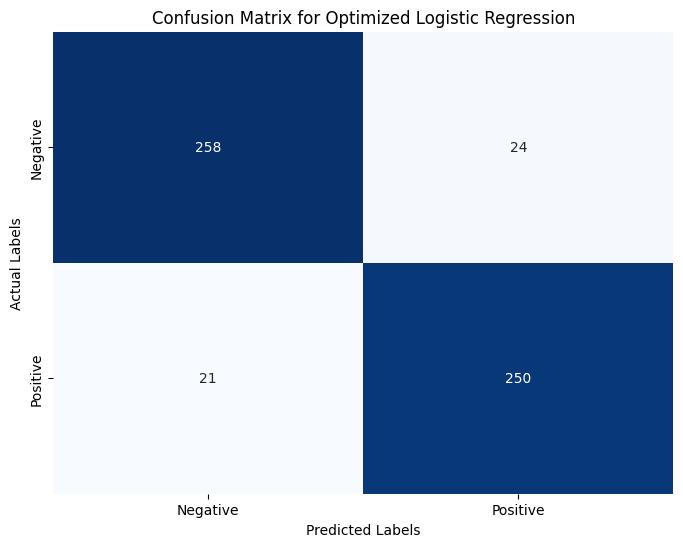

In [ ]:
cm = confusion_matrix(y_test, y_pred_lr_opt)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.title('Confusion Matrix for Optimized Logistic Regression')
plt.xticks([0.5, 1.5], ['Negative', 'Positive'])
plt.yticks([0.5, 1.5], ['Negative', 'Positive'])
plt.show()

In [ ]:
# Evaluate Optimized SVM
evaluate_model(y_test, y_pred_svm_opt, "Optimized SVM")

Model: Optimized SVM
Confusion Matrix:
[[262  20]
 [ 15 256]]
Accuracy: 0.94
Precision: 0.93
Recall: 0.94
F1-Score: 0.94
Specificity: 0.93
AUC-ROC: 0.94
MCC: 0.87




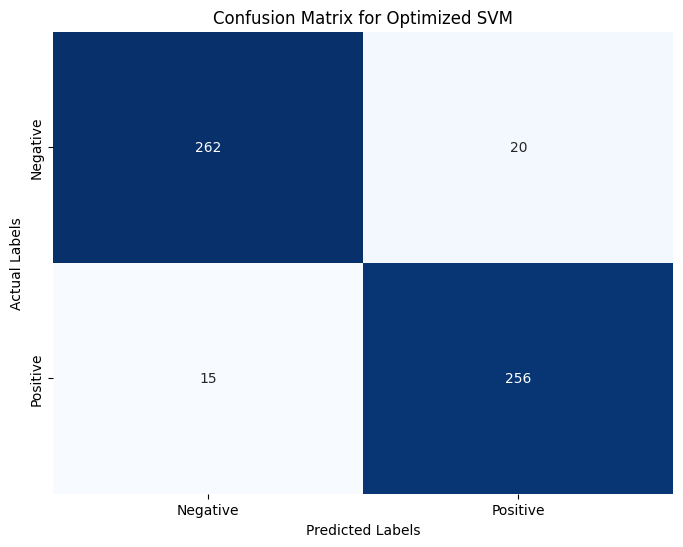

In [ ]:
cm = confusion_matrix(y_test, y_pred_svm_opt)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.title('Confusion Matrix for Optimized SVM')
plt.xticks([0.5, 1.5], ['Negative', 'Positive'])
plt.yticks([0.5, 1.5], ['Negative', 'Positive'])
plt.show()

In [ ]:
# Evaluate Optimized XGBoost
evaluate_model(y_test, y_pred_xgb_opt, "Optimized XGBoost")

Model: Optimized XGBoost
Confusion Matrix:
[[264  18]
 [ 15 256]]
Accuracy: 0.94
Precision: 0.93
Recall: 0.94
F1-Score: 0.94
Specificity: 0.94
AUC-ROC: 0.94
MCC: 0.88




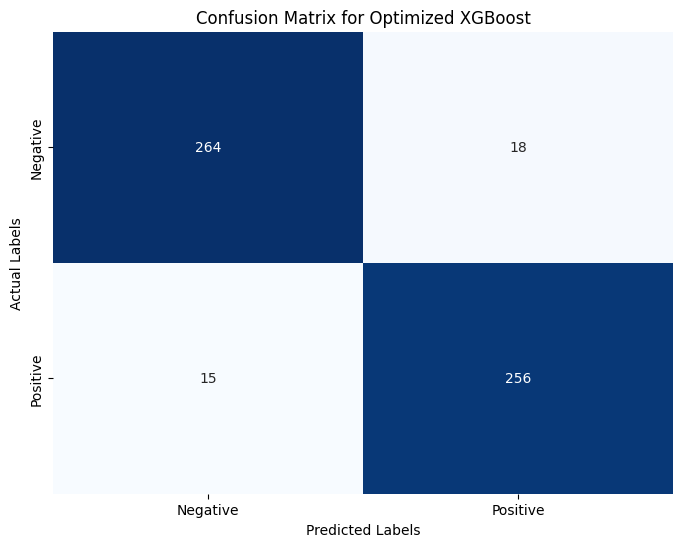

In [ ]:
cm = confusion_matrix(y_test, y_pred_xgb_opt)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.title('Confusion Matrix for Optimized XGBoost')
plt.xticks([0.5, 1.5], ['Negative', 'Positive'])
plt.yticks([0.5, 1.5], ['Negative', 'Positive'])
plt.show()

In [ ]:
evaluate_model(y_test, y_pred_hard,"Voting Classifier")

Model: Voting Classifier
Confusion Matrix:
[[264  18]
 [ 14 257]]
Accuracy: 0.94
Precision: 0.93
Recall: 0.95
F1-Score: 0.94
Specificity: 0.94
AUC-ROC: 0.94
MCC: 0.88




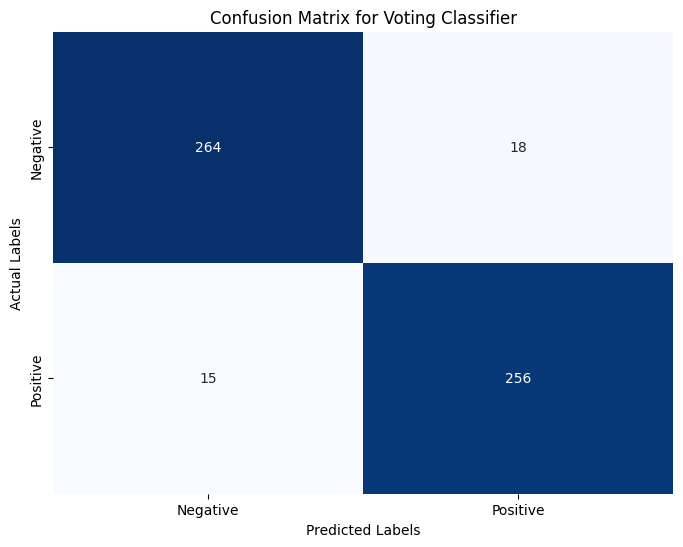

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)  # Change the cmap parameter to "PuRd"
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.title('Confusion Matrix for Voting Classifier')
plt.xticks([0.5, 1.5], ['Negative', 'Positive'])
plt.yticks([0.5, 1.5], ['Negative', 'Positive'])
plt.show()


In [ ]:
"""
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Confusion matrices for Logistic Regression and SVM
cm_lr = confusion_matrix(y_test, y_pred_lr)
cm_svm = confusion_matrix(y_test, y_pred_svm)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Logistic Regression Confusion Matrix
sns.heatmap(cm_lr, annot=True, fmt="d", cmap="Blues", ax=ax[0])
ax[0].set_title('Logistic Regression Confusion Matrix')
ax[0].set_xlabel('Predicted Labels')
ax[0].set_ylabel('Actual Labels')
ax[0].set_xticklabels(['Human', 'AI'])
ax[0].set_yticklabels(['Human', 'AI'])

# SVM Confusion Matrix
sns.heatmap(cm_svm, annot=True, fmt="d", cmap="Greens", ax=ax[1])
ax[1].set_title('SVM Confusion Matrix')
ax[1].set_xlabel('Predicted Labels')
ax[1].set_ylabel('Actual Labels')
ax[1].set_xticklabels(['Human', 'AI'])
ax[1].set_yticklabels(['Human', 'AI'])

plt.tight_layout()
plt.show()

"""

'\nimport matplotlib.pyplot as plt\nfrom sklearn.metrics import confusion_matrix\nimport seaborn as sns\n\n# Confusion matrices for Logistic Regression and SVM\ncm_lr = confusion_matrix(y_test, y_pred_lr)\ncm_svm = confusion_matrix(y_test, y_pred_svm)\n\nfig, ax = plt.subplots(1, 2, figsize=(12, 5))\n\n# Logistic Regression Confusion Matrix\nsns.heatmap(cm_lr, annot=True, fmt="d", cmap="Blues", ax=ax[0])\nax[0].set_title(\'Logistic Regression Confusion Matrix\')\nax[0].set_xlabel(\'Predicted Labels\')\nax[0].set_ylabel(\'Actual Labels\')\nax[0].set_xticklabels([\'Human\', \'AI\'])\nax[0].set_yticklabels([\'Human\', \'AI\'])\n\n# SVM Confusion Matrix\nsns.heatmap(cm_svm, annot=True, fmt="d", cmap="Greens", ax=ax[1])\nax[1].set_title(\'SVM Confusion Matrix\')\nax[1].set_xlabel(\'Predicted Labels\')\nax[1].set_ylabel(\'Actual Labels\')\nax[1].set_xticklabels([\'Human\', \'AI\'])\nax[1].set_yticklabels([\'Human\', \'AI\'])\n\nplt.tight_layout()\nplt.show()\n\n'

In [ ]:
def evaluate_predictions(true_labels, predicted_labels, model_name, d):
    evaluation_df = pd.DataFrame({'True_Label': true_labels, 'Predicted_Label': predicted_labels})
    evaluation_df = pd.merge(d, evaluation_df, left_index=True, right_index=True)

    misclassified_sentences = evaluation_df[(evaluation_df['True_Label'] == 0) &
                                             (evaluation_df['True_Label'] != evaluation_df['Predicted_Label'])]

    return misclassified_sentences

In [ ]:
lr_mis = evaluate_predictions(y_test, y_pred_lr_opt, "Optimized Logistic Regression", d)
svm_mis = evaluate_predictions(y_test, y_pred_svm_opt, "Optimized SVM", d)
xgb_mis = evaluate_predictions(y_test, y_pred_xgb_opt, "Optimized XGBoost", d)
voting_mis = evaluate_predictions(y_test, y_pred_hard, "Voting Classifier", d)

In [ ]:
# Merge voting_mis and xgb_mis DataFrames
merged_df = pd.merge(voting_mis, xgb_mis, left_index=True, right_index=True, suffixes=('_voting', '_xgb'))
selected_columns = [col for col in merged_df.columns if col.endswith('_xgb')]

# Merge selected columns with lr_mis DataFrame
merged_df_lr = pd.merge(merged_df[selected_columns], lr_mis, left_index=True, right_index=True, suffixes=('_merged', '_lr'))
selected_columns = [col for col in merged_df_lr.columns if col.endswith('_lr')]

# Merge merged_df_lr with svm_mis DataFrame
final_df = pd.merge(merged_df_lr[selected_columns], svm_mis, left_index=True, right_index=True, suffixes=('_final', '_svm'))
final_cols = [col for col in final_df.columns if col.endswith('_final')]


In [ ]:
final_df.shape

(11, 23)

In [ ]:
filename = 'data_misclassified.csv'
final_df.to_csv(filename, index=False)

#Deployment

##Serializing ml models

In [ ]:
import pickle

filename = 'llm_detect_AIML.pkl'

# Save model (serialize)
pickle.dump(svc_grid, open(filename, 'wb'))

# Load model (de-serialize)
pickle.load(open(filename, 'rb'))


#Deep Learning Models

In [ ]:
file_paths = ['LLM_generated_essay_PaLM.csv', 'train_essays.csv']  # file paths

# Function to load and preprocess data
def load_and_preprocess_data(file_paths):
    dfs = [pd.read_csv(file_path) for file_path in file_paths]
    DL = pd.concat(dfs, ignore_index=True)
    # Remove 'id' column
    DL = DL.drop('id', axis=1)

# Convert 'prompt_id' and 'generated' columns from float to integer
    DL['prompt_id'] = DL['prompt_id'].astype(int)
    DL['generated'] = DL['generated'].astype(int)
    return DL

DL = load_and_preprocess_data(file_paths)

##BERT

###Import neccessary libraries

In [ ]:
!pip install accelerate -U
!pip install transformers[torch] -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.6/297.6 kB 5.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [ ]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 15.3 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3


In [ ]:
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict, load_metric
from transformers import BertTokenizer, BertModel, TrainingArguments, Trainer, DataCollatorWithPadding
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
Bert_data = DL

In [ ]:
#Train the model

X = Bert_data[['text']]  # Features need to be in DataFrame format
y = Bert_data['generated']  # Labels

# Splitting the dataset into train/test with corresponding features and labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Further splitting the training set into train/validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)  # Note: 0.25 * 0.8 = 0.2

# Creating DataFrames from the splits to ensure each split has both features and labels
train_df = pd.concat([X_train, y_train], axis=1)
val_df = pd.concat([X_val, y_val], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

# Converting the DataFrames to Hugging Face Dataset objects
train_ds = Dataset.from_pandas(train_df)
val_ds = Dataset.from_pandas(val_df)
test_ds = Dataset.from_pandas(test_df)

# Organizing the datasets into a DatasetDict
ds = DatasetDict({
    'train': train_ds,
    'validation': val_ds,
    'test': test_ds
})


In [ ]:
#Tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

def tokenizer_sentence(data):
    return tokenizer(data['text'], padding="max_length", truncation=True, max_length=128)

tokenized_ds = ds.map(tokenizer_sentence, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


In [ ]:
#Bert Model
class CustomBertModel(nn.Module):
    def __init__(self, num_labels):
        super(CustomBertModel, self).__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)
        # CrossEntropyLoss initialization moved to forward method

    def forward(self, input_ids, attention_mask=None, labels=None):
        print("Received input keys:", locals().keys())
        output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = output.pooler_output
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        # Calculate loss only if labels are provided
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            # Assuming labels are provided as LongTensors
            loss = loss_fct(logits.view(-1, self.classifier.out_features), labels.view(-1))
            return {"loss": loss, "logits": logits}
        else:
            return {"logits": logits}
model = CustomBertModel(num_labels=2)

model

In [ ]:
tokenized_ds = tokenized_ds.map(lambda examples: {'labels': examples['generated']}, remove_columns=['generated'])

In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir="./logs",
    evaluation_strategy="epoch",  # Evaluate at the end of each epoch
    logging_steps=10,  # Log metrics every 10 steps
)

In [ ]:
#evaluation metric function

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def compute_metrics(pred):
    logits, labels = pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = accuracy_score(labels, predictions)
    precision = precision_score(labels, predictions, average='binary')
    recall = recall_score(labels, predictions, average='binary')
    f1 = f1_score(labels, predictions, average='binary')
    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_ds["train"],
    eval_dataset=tokenized_ds["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [ ]:
import numpy as np

In [ ]:
# Call train & evaluate functions
trainer.train()
trainer.evaluate()

In [ ]:
##Loss curve
log_history = pd.DataFrame(trainer.state.log_history)
log_history.head()
log_history.info()

#plot the loss curve
# Filter out rows where `epoch` has non-null losses
training_loss_per_epoch = log_history[log_history['loss'].notnull()].groupby('epoch')['loss'].mean().reset_index()
validation_loss_per_epoch = log_history[log_history['eval_loss'].notnull()][['epoch', 'eval_loss']].dropna()

# Ensure epochs are correctly aligned and sorted
training_loss_per_epoch = training_loss_per_epoch.sort_values('epoch')
validation_loss_per_epoch = validation_loss_per_epoch.sort_values('epoch')

plt.figure(figsize=(10, 6))
plt.plot(training_loss_per_epoch['epoch'], training_loss_per_epoch['loss'], label='Training Loss', marker='o')
plt.plot(validation_loss_per_epoch['epoch'], validation_loss_per_epoch['eval_loss'], label='Validation Loss', marker='x')
plt.title('Training vs. Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#Print Test results
test_results = trainer.predict(tokenized_ds["test"])
print(test_results)

In [ ]:
import numpy as np
from scipy.special import softmax

# Assuming `test_results` is your PredictionOutput object
logits = test_results.predictions
probabilities = softmax(logits, axis=1)
predicted_classes = np.argmax(probabilities, axis=1)

test_df['predicted'] = predicted_classes
test_df.head()

In [ ]:
##Classification Report on test data
from sklearn.metrics import classification_report

print(classification_report(test_df['generated'], test_df['predicted']))

In [ ]:
from sklearn.metrics import confusion_matrix

# test_df['generated']` are the true labels and `test_df['predicted']` are the model predictions
cm = confusion_matrix(test_df['generated'], test_df['predicted'])
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1], yticklabels=[0, 1])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


## **Roberta**

In [ ]:
#Load data
roberta_train = DL

In [ ]:
!pip install evaluate

In [ ]:
## import libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from torch.utils.data import DataLoader, Dataset
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup
import torch

import matplotlib.pyplot as plotter
import plotly.graph_objects as go
import plotly.express as px

from sklearn.model_selection import train_test_split
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# SET GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        strategy = tf.distribute.OneDeviceStrategy(device="/gpu:0")
    except RuntimeError as e:
        print(e)
else:
    strategy = tf.distribute.get_strategy()
    print('Number of replicas:', strategy.num_replicas_in_sync)

In [ ]:
import os
os.environ["WANDB_API_KEY"] = "0"

In [ ]:
roberta_train=roberta_train.rename(columns={'generated': "label"})
roberta_train

In [ ]:
train, test = train_test_split(roberta_train, test_size=0.2, random_state=42)
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

In [ ]:
print("head")
display(train.head())
display(test.head())
print("info")
display(train.info())
display(test.info())

**Model XLM-Roberta**

In [ ]:
import evaluate
import torch
from transformers import AdamW, AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding, TrainingArguments, Trainer

In [ ]:
model_name = 'symanto/xlm-roberta-base-snli-mnli-anli-xnli'
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [ ]:
train.columns
test.columns

In [ ]:
# delete unnecessary columns
train = train.drop(labels=['prompt_id'], axis=1)
test = test.drop(labels=['prompt_id'], axis=1)

In [ ]:
from datasets import Dataset, DatasetDict

In [ ]:
train_df, val_df = train_test_split(train, test_size=0.2, random_state=42)


train_ds = Dataset.from_pandas(train_df)
val_ds = Dataset.from_pandas(val_df)
test_ds = Dataset.from_pandas(test)

ds = DatasetDict()
ds['train'] = train_ds
ds['validation'] = val_ds
ds['test'] = test_ds

In [ ]:
def tokenizer_sentence(data):
    return tokenizer(data['text'], truncation=True)  #feature columns

**MAP**

In [ ]:
tokenized_ds = ds.map(tokenizer_sentence, batched=True)
tokenized_ds

In [ ]:
from datasets import Dataset, DatasetDict

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)



import torch.nn as nn
from transformers import XLMRobertaModel

class CustomXLMRobertaModel(nn.Module):
    def __init__(self, num_labels):
        super(CustomXLMRobertaModel, self).__init__()
        model_name = 'symanto/xlm-roberta-base-snli-mnli-anli-xnli'
        self.roberta = XLMRobertaModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Sequential(
            nn.Linear(768, 512),
            nn.LayerNorm(512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, num_labels)
        )
        self.loss = nn.CrossEntropyLoss()
        self.num_labels = num_labels

    def forward(self, input_ids, attention_mask, labels=None):
        output = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        output = self.dropout(output.pooler_output)
        logits = self.classifier(output)

        if labels is not None:
            loss = self.loss(logits.view(-1, self.num_labels), labels.view(-1))
            return {"loss": loss, "logits": logits}
        else:
            return logits



model = CustomXLMRobertaModel(num_labels=2)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score
from datasets import load_metric

training_args = TrainingArguments(output_dir="roberta-large-lora-token-classification",
                                  optim="adamw_torch",
                                  num_train_epochs=3,
                                  evaluation_strategy="epoch",
                                 # per_device_train_batch_size=8,
                                  #per_device_eval_batch_size=8,
                                  logging_dir='./logs',
                                   weight_decay=0.01,
                                  logging_steps=10,
                                report_to="none")

f1_metric = load_metric("f1")
precision_metric = load_metric('precision')
recall_metric = load_metric("recall")
def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)
    return {
        'accuracy': accuracy_score(labels, predictions),
        'precision': precision_metric.compute(predictions=predictions, references=labels, average="micro"),
        'f1': f1_metric.compute(predictions=predictions, references=labels, average="micro"),
                'recall': recall_metric.compute(predictions=predictions, references=labels, average="micro")['recall']
        }

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model,
    args=training_args,
    train_dataset=tokenized_ds["train"],
    eval_dataset=tokenized_ds["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

In [ ]:
!pip install wandb

In [ ]:
import os
os.environ["WANDB_DISABLED"] = "false"

In [ ]:
history=trainer.train()

In [ ]:
predictions = trainer.predict(tokenized_ds["test"])
predictions

In [ ]:
logits = torch.from_numpy(predictions.predictions)
logits

In [ ]:
test_pred_df=pd.DataFrame(logits)
test_pred_df

In [ ]:
test_pred_df=test_pred_df[0]
test_pred_df=pd.DataFrame(test_pred_df)
test_pred_df

In [ ]:
test_pred_df[0][test_pred_df[0] <= 0] = 0
test_pred_df[0][test_pred_df[0] > 0] = 1
test_pred_df[0] = test_pred_df[0].replace({0:1,1:0})

In [ ]:
test_pred_df=test_pred_df.set_axis(axis=1,labels=['Test_pred'])
test_pred_df

In [ ]:
test_pred_all=test.merge(test_pred_df,how='inner',left_index=True,right_index=True)
test_pred_all


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
acc = accuracy_score(test_pred_all['label'], test_pred_all['Test_pred'])
print("accuracy is: {0:.3f}%".format(acc * 100))
cm = confusion_matrix(test_pred_all['label'] , test_pred_all['Test_pred'])
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt='.0f')
plt.xlabel("Predicted Digits")
plt.ylabel("True Digits")
plt.show()

In [ ]:
log_history = pd.DataFrame(trainer.state.log_history)
log_history.head()
log_history.info()

In [ ]:

from sklearn.metrics import classification_report

print(classification_report(test_pred_all['label'], test_pred_all['Test_pred']))

#MLP

In [ ]:
import pandas as pd
file_paths = ['data.csv']  # file paths
data1 = pd.read_csv('data.csv')
#data1 = load_and_preprocess_data(file_paths)
data1.drop('prompt_id',axis=1,inplace=True)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy: 0.9529837251356239
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       273
           1       0.95      0.95      0.95       280

    accuracy                           0.95       553
   macro avg       0.95      0.95      0.95       553
weighted avg       0.95      0.95      0.95       553



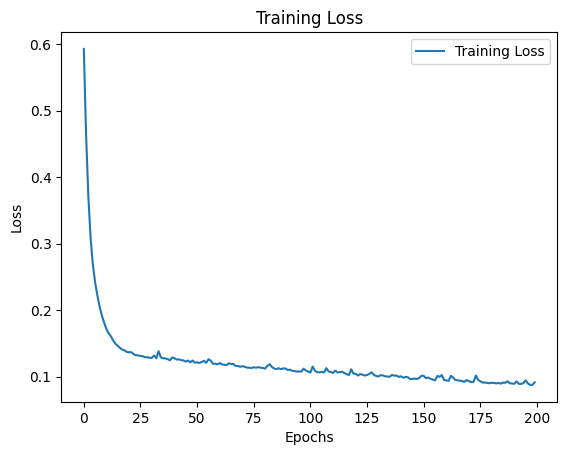

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

# Define feature columns and target variable
feature_columns = ['Mean', 'word_count', 'vocab', 'Min', 'subjectivity', 'named_entities_', 'syntactic_complexity']
X = data1[feature_columns]
y = data1['generated']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features by removing the mean and scaling to unit variance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create MLP model
mlp_model = MLPClassifier(hidden_layer_sizes=(100, 50), activation='relu', solver='adam', random_state=42)

# Train the model and track history
history = mlp_model.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred = mlp_model.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:")
print(classification_report(y_test, y_pred))


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 7)]                  0         []                            
                                                                                                  
 dense_243 (Dense)           (None, 64)                   512       ['input_1[0][0]']             
                                                                                                  
 dropout_162 (Dropout)       (None, 64)                   0         ['dense_243[0][0]']           
                                                                                                  
 dense_244 (Dense)           (None, 64)                   4160      ['dropout_162[0][0]']         
                                                                                              

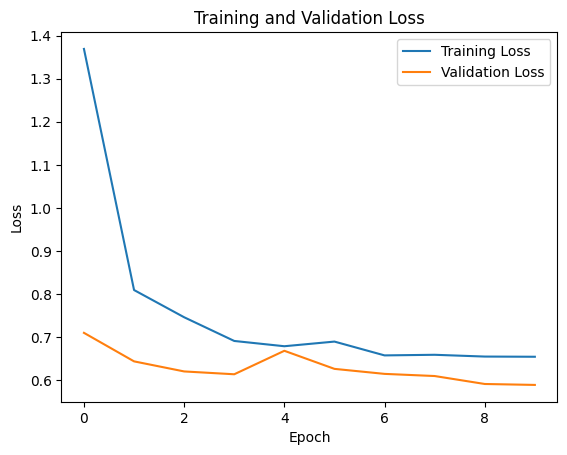

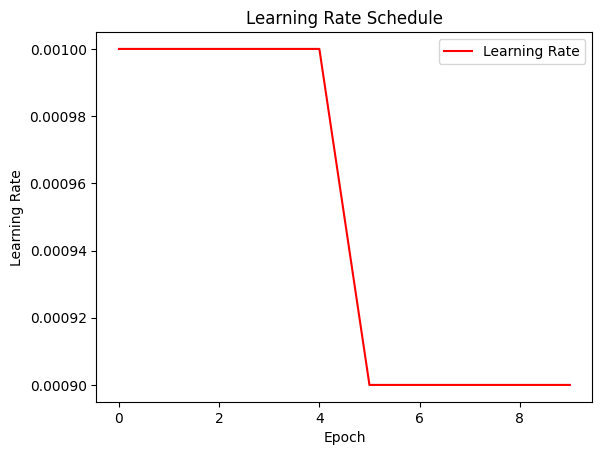

18/18 [==============================] - 0s 3ms/step - loss: 0.5886 - accuracy: 0.7215 - precision_81: 0.9091
Test Loss: 0.5885772109031677
Test Accuracy: 0.7215189933776855
Test Precision: 0.9090909361839294
18/18 [==============================] - 0s 2ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.95      0.77       273
           1       0.91      0.50      0.65       280

    accuracy                           0.72       553
   macro avg       0.78      0.72      0.71       553
weighted avg       0.78      0.72      0.71       553



In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Dense, Dropout, Multiply
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split

# Define input shape
input_shape = X_train.shape[1]

# Define hyperparameters
learning_rate = 0.001
num_layers = 3
num_units = 64
dropout_rate = 0.1

# Input layer
inputs = Input(shape=(input_shape,))

# Dense layers with dropout and gating
x = inputs
for _ in range(num_layers):
    x = Dense(num_units, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    gate_output = Dense(num_units, activation='sigmoid')(x)
    x = Multiply()([x, gate_output])

# Output layer
outputs = Dense(1, activation='sigmoid')(x)

# Build model
model = Model(inputs=inputs, outputs=outputs)

# Compile model with precision metric
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision()])

# Print model summary
model.summary()

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define learning rate scheduler
def scheduler(epoch, lr):
    if epoch % 5 == 0 and epoch != 0:
        return lr * 0.9
    else:
        return lr

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

# Train model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32, callbacks=[lr_scheduler])

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot learning rate
plt.plot(history.history['lr'], label='Learning Rate', color='r')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Schedule')
plt.legend()
plt.show()

loss, accuracy, precision = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)
print("Test Precision:", precision)

from sklearn.metrics import classification_report

# Make predictions on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Generate classification report
report = classification_report(y_test, y_pred_binary)
print("Classification Report:")
print(report)


Miclassified indices in MLP

In [ ]:
import numpy as np

# Convert probabilities to binary predictions
y_pred_binary = (y_pred > 0.5).astype(int)

# Find misclassified samples
misclassified_indices = np.where((y_test == 0) & (y_pred_binary.flatten() == 1))[0]

# Print misclassified indices
print("Misclassified indices:", misclassified_indices)

# Extract misclassified samples from the original dataset
#misclassified_samples = X_test[misclassified_indices]

# Print misclassified samples
#print("Misclassified samples:")
#print(misclassified_samples)

#evaluate_predictions(y_test, y_pred_binary, "mlp", data1)

Misclassified indices: [111 115 117 236 264 277 291 313 317 328 348 349 509 518]


## Misclassified

In [ ]:
import pandas as pd
file_paths = ['data_misclassified.csv']  # file paths
final_df = pd.read_csv('data_misclassified.csv')
data1 = pd.read_csv('data.csv')
data1.drop('prompt_id',axis=1,inplace=True)

In [ ]:
final_df

,prompt_id,text,generated,processed_text,essay_length,avg_sentence_length,pos_tags,vocab,sentiment,subjectivity,...,word_count,named_entities,named_entities_,pos_tags_,Row,Min,Max,Mean,True_Label,Predicted_Label
0,0,What would it be like to live in a society wit...,0,would like live societi without use car well c...,233,233.0,"Counter({'NN': 133, 'JJ': 34, 'CD': 11, 'VB': ...",0.497573,Positive,0.394792,...,412,"['VAUBAN', 'Germany', 'Europe', 'United States...",10,17,111,0.017642,0.352680,0.070784,0,1
1,1,"Dear state senator, It is highly unlikely that...",0,dear state senat highli unlik read hey worth s...,237,237.0,"Counter({'NN': 138, 'JJ': 41, 'VBP': 14, 'VB':...",0.365019,Positive,0.600407,...,526,"['United States', 'Source', 'Hawaii', 'United ...",4,13,141,0.021669,0.371213,0.073794,0,1
2,0,"Cars have helped people over the years, but ha...",0,car help peopl year help environ heath drive c...,205,205.0,"Counter({'NN': 134, 'JJ': 21, 'IN': 8, 'RB': 8...",0.475578,Positive,0.414815,...,389,"['Elisabeth Rosenthal', 'United States', 'Robe...",7,15,354,0.015179,0.501173,0.066095,0,1
3,1,Imagine that the president the majority of the...,0,imagin presid major peopl vote win elector col...,177,177.0,"Counter({'NN': 101, 'JJ': 23, 'VB': 11, 'VBP':...",0.485030,Positive,0.646191,...,334,"['Imagine', 'United States', 'Source', 'Louisi...",10,13,572,0.022907,0.429068,0.083864,0,1
4,1,"Dear State Senator, I think that we should cha...",0,dear state senat think chang elect popular vot...,164,164.0,"Counter({'NN': 78, 'JJ': 26, 'VBP': 18, 'VB': ...",0.488827,Positive,0.619048,...,358,"['Dear State Senator', 'United States', 'Unite...",13,13,1001,0.025621,0.304803,0.088420,0,1
5,0,Limiting car usage will have many advantages. ...,0,limit car usag mani advantag reduc pollut also...,190,190.0,"Counter({'NN': 95, 'JJ': 23, 'RB': 18, 'VB': 1...",0.494253,Positive,0.419697,...,348,"['Car', 'United States', 'U.S.', 'U.S.', 'U.S....",6,14,1475,0.022041,0.361485,0.079282,0,1
6,1,"Dear Senator, I think you should get rid of th...",0,dear senat think get rid elector colleg use po...,200,200.0,"Counter({'NN': 119, 'JJ': 29, 'VBP': 15, 'RB':...",0.408269,Positive,0.672826,...,387,"['Dear Senator', 'College', 'Senator']",3,14,1628,0.019586,0.424541,0.080023,0,1
7,1,Electoral Colleges is something many people di...,0,elector colleg someth mani peopl disagre idea ...,174,174.0,"Counter({'NN': 98, 'JJ': 27, 'VBP': 22, 'VB': ...",0.426997,Positive,0.500929,...,363,['Colleges'],1,13,1765,0.023465,0.427936,0.086200,0,1
8,1,"Dear Florida state senator, I argue in favor o...",0,dear florida state senat argu favor keep elect...,181,181.0,"Counter({'NN': 100, 'JJ': 30, 'VB': 13, 'VBP':...",0.531447,Positive,0.629861,...,318,"['Dear Florida', 'Florida', 'Runoff Elections'...",6,10,1844,0.022905,0.385981,0.082372,0,1
9,0,"People use cars everyday, but limiting car usa...",0,peopl use car everyday limit car usag benefici...,285,285.0,"Counter({'NN': 168, 'JJ': 53, 'VBP': 13, 'JJR'...",0.489194,Positive,0.380165,...,509,"['Chicago', 'Shanghai', 'Smog', 'France', 'Lim...",5,16,2380,0.018922,0.479260,0.066259,0,1


In [ ]:
final_df.describe()

,prompt_id,generated,essay_length,avg_sentence_length,vocab,subjectivity,polarity,readability,syntactic_complexity,word_count,named_entities_,pos_tags_,Row,Min,Max,Mean,True_Label,Predicted_Label
count,10.000000,10.0,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.00000,10.000000,10.000000,10.000000,10.000000,10.000000,10.0,10.0
mean,0.600000,0.0,204.600000,204.600000,0.466219,0.527873,0.233179,-131.972000,117.400000,394.400000,6.50000,13.800000,1127.100000,0.020994,0.403814,0.077709,0.0,1.0
std,0.516398,0.0,37.205734,37.205734,0.050158,0.117248,0.141025,40.678622,26.870885,70.548959,3.62859,1.932184,802.020289,0.003122,0.060010,0.008052,0.0,0.0
min,0.000000,0.0,164.000000,164.000000,0.365019,0.380165,0.006610,-217.810000,79.000000,318.000000,1.00000,10.000000,111.000000,0.015179,0.304803,0.066095,0.0,1.0
25%,0.000000,0.0,178.000000,178.000000,0.439143,0.416035,0.101665,-153.355000,99.500000,350.500000,4.25000,13.000000,408.500000,0.019088,0.363917,0.071536,0.0,1.0
50%,1.000000,0.0,195.000000,195.000000,0.486928,0.550668,0.287898,-124.765000,111.000000,375.000000,6.00000,13.500000,1238.000000,0.021855,0.405261,0.079652,0.0,1.0
75%,1.000000,0.0,226.000000,226.000000,0.492988,0.627158,0.326302,-111.320000,134.750000,406.250000,9.25000,14.750000,1730.750000,0.022906,0.428785,0.083491,0.0,1.0
max,1.000000,0.0,285.000000,285.000000,0.531447,0.672826,0.383929,-79.760000,169.000000,526.000000,13.00000,17.000000,2380.000000,0.025621,0.501173,0.088420,0.0,1.0


In [ ]:
final_df['word_count'].describe()

count     10.000000
mean     394.400000
std       70.548959
min      318.000000
25%      350.500000
50%      375.000000
75%      406.250000
max      526.000000
Name: word_count, dtype: float64

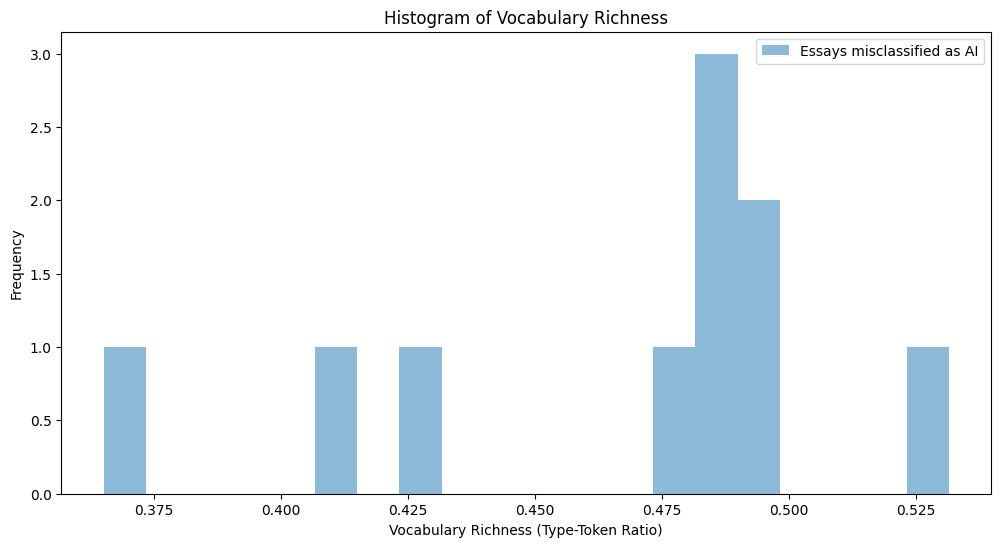

In [ ]:
plt.figure(figsize=(12, 6))
plt.hist(final_df[final_df['generated'] == 0]['vocab'], bins=20, alpha=0.5, label='Essays misclassified as AI')
plt.title('Histogram of Vocabulary Richness')
plt.xlabel('Vocabulary Richness (Type-Token Ratio)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [ ]:
final_df['vocab'].describe()

count    10.000000
mean      0.466219
std       0.050158
min       0.365019
25%       0.439143
50%       0.486928
75%       0.492988
max       0.531447
Name: vocab, dtype: float64

In [ ]:
final_df[final_df['generated'] == 0]['syntactic_complexity'].describe()

count     10.000000
mean     117.400000
std       26.870885
min       79.000000
25%       99.500000
50%      111.000000
75%      134.750000
max      169.000000
Name: syntactic_complexity, dtype: float64

In [ ]:
import pandas as pd

# Calculate describe statistics for each DataFrame
df1_desc = final_df[final_df['generated'] == 0]['syntactic_complexity'].describe()
df2_desc = data1[data1['generated'] == 0]['syntactic_complexity'].describe()
df3_desc = data1[data1['generated'] == 1]['syntactic_complexity'].describe()

# Concatenate into a single DataFrame
df_combined = pd.concat([df1_desc, df2_desc, df3_desc], axis=1)
df_combined.columns = ['Misclassified', 'Human-Written', 'AI-Generated']

# Display the combined DataFrame
print(df_combined)

       Misclassified  Human-Written  AI-Generated
count      10.000000    1375.000000   1387.000000
mean      117.400000     159.381818    119.959625
std        26.870885      52.358220     28.764378
min        79.000000      64.000000     59.000000
25%        99.500000     123.000000     98.000000
50%       111.000000     147.000000    119.000000
75%       134.750000     184.000000    140.000000
max       169.000000     561.000000    246.000000


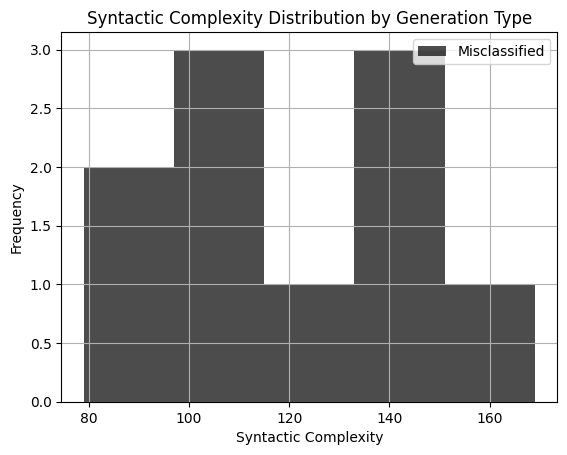

In [ ]:
plt.hist(final_df[final_df['generated'] == 0]['syntactic_complexity'], bins=5, color='black', alpha=0.7, label='Misclassified')

# Adding labels and title
plt.title('Syntactic Complexity Distribution by Generation Type')
plt.xlabel('Syntactic Complexity')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

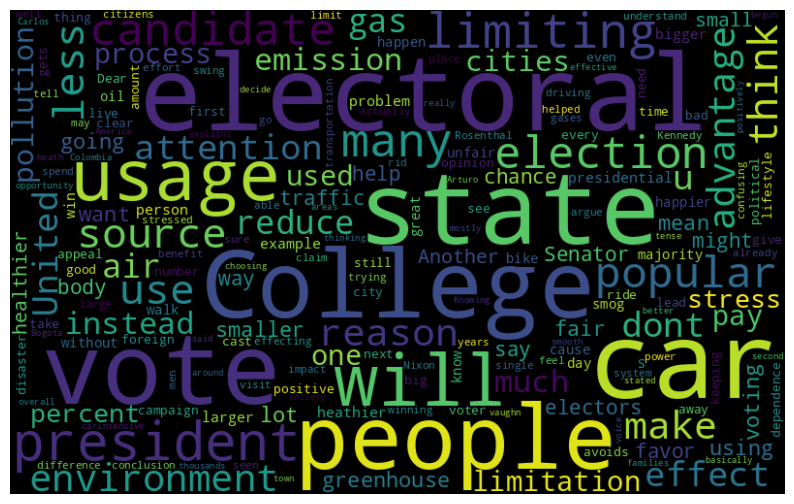

In [ ]:
from wordcloud import WordCloud

dataai = final_df[final_df["generated"] == 0]
all_words = ' '.join([text for text in dataai.text])

wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(all_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

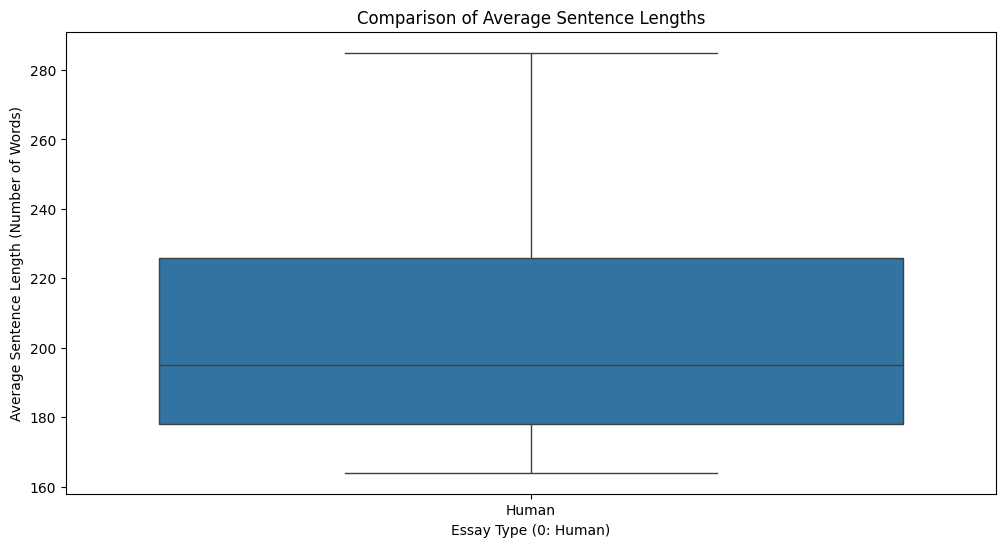

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='generated', y='avg_sentence_length', data=final_df)
plt.title('Comparison of Average Sentence Lengths')
plt.xlabel('Essay Type (0: Human)')
plt.ylabel('Average Sentence Length (Number of Words)')
plt.xticks([0], ['Human'])
plt.show()

In [ ]:
nltk.download('words')

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


True

Coherence and Consistency Statistics:
+-----------+------------+--------------------+
| generated | word_count |       vocab        |
+-----------+------------+--------------------+
|     0     |   394.4    | 0.4662186881363305 |
+-----------+------------+--------------------+


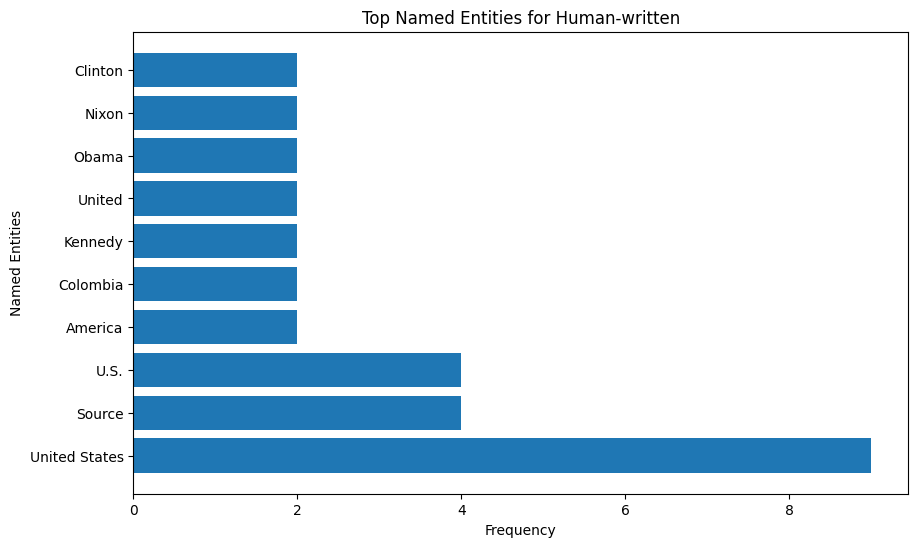

In [ ]:
def extract_named_entities(text):
    sentences = nltk.sent_tokenize(text)
    tokenized_sentences = [nltk.word_tokenize(sentence) for sentence in sentences]
    tagged_sentences = [nltk.pos_tag(sentence) for sentence in tokenized_sentences]
    chunked_sentences = nltk.ne_chunk_sents(tagged_sentences, binary=True)

    named_entities = []
    for chunked_sentence in chunked_sentences:
        for subtree in chunked_sentence:
            if type(subtree) == nltk.tree.Tree:
                entity = " ".join([token for token, pos in subtree.leaves()])
                entity_type = subtree.label()
                named_entities.append(entity)

    return named_entities

# Function to calculate coherence and consistency metrics
def calculate_coherence_consistency(data):
    # For demonstration purposes, let's assume coherence and consistency are based on word count and vocabulary richness.
    data['word_count'] = data['text'].apply(lambda x: len(x.split()))
    data['vocab'] = data['text'].apply(lambda x: len(set(x.split())) / len(x.split()))

    # Group by 'generated' column (0 for human-written, 1 for AI-generated) and calculate mean coherence and consistency
    coherence_consistency_stats = data.groupby('generated')[['word_count', 'vocab']].mean()

    return coherence_consistency_stats



def extract_and_aggregate_named_entities(data):

    human_named_entities = []

    for index, row in data.iterrows():
        named_entities = extract_named_entities(row['text'])
        if named_entities is not None:
            if row['generated'] == 0:
                human_named_entities.extend(named_entities)

    return human_named_entities


def visualize_most_common_named_entities(named_entities, label):
    if not named_entities:
        print(f"No named entities found for {label}.")
        return

    # Count the occurrences of each named entity
    entity_counts = Counter(named_entities)

    # Plot the top N named entities
    top_n = 10
    top_entities = entity_counts.most_common(top_n)
    entities, counts = zip(*top_entities)

    plt.figure(figsize=(10, 6))
    plt.barh(entities, counts)
    plt.xlabel('Frequency')
    plt.ylabel('Named Entities')
    plt.title(f'Top Named Entities for {label}')
    plt.show()


# Calculate coherence and consistency
coherence_consistency_stats = calculate_coherence_consistency(final_df)
print("Coherence and Consistency Statistics:")
print(tabulate(coherence_consistency_stats, headers='keys', tablefmt='pretty'))

# Aggregate named entities for AI-generated and human-written essays
human_named_entities = extract_and_aggregate_named_entities(final_df)

# Visualize the most common named entities for AI-generated and human-written essays
visualize_most_common_named_entities(human_named_entities, "Human-written")

# Aggregate counts of named entities for AI-generated and human-written essays
human_counts = pd.Series(human_named_entities).value_counts()

# Create a DataFrame to display the counts of named entities for generated 0 and generated 1
#counts_df = pd.DataFrame({'Generated 0': human_counts}).fillna(0)

# Display the DataFrame
#print("\nCounts of Named Entities:")
#print(counts_df)

# Count the occurrences of each named entity for AI-generated and human-written essays
human_entity_counts = Counter(human_named_entities)

# Get the highest count of NERs for each group
human_highest_count = human_entity_counts.most_common(1)[0][1]

# Add a new column to the dataframe with named entities for each row
#data['named_entities'] = data['text'].apply(lambda x: extract_named_entities(x))

# Display the first few rows to verify the addition
#print(data.head())
